## Phase 4: Behavioral-Mechanistic Linkage Analysis

### Overview
Phase 3 revealed that deeper transformer layers develop "specialist" features that activate selectively for specific text categories. But what are these specialists actually detecting — the underlying **semantic meaning** or merely **surface-level syntactic patterns**?

This phase tests whether semantically equivalent content presented in different surface forms (symbolic notation vs. verbal description vs. prose explanation) activates the same or different features.

### Objectives
1. Test whether the syntactic (rather than semantic) nature of specialist features has measurable consequences for model behavior
2. Compare specialist feature activation across semantically equivalent inputs that vary in surface form
3. Investigate how the model represents semantically equivalent expressions internally
4. Determine whether model accuracy correlates with specialist feature activation strength
5. Validate Phase 3 findings through behavioral experiments

### What We'll Learn
* Whether specialist features' surface-level pattern detection has downstream behavioral consequences
* How strongly surface form (symbolic vs. verbal vs. prose) affects internal representations
* Whether cosine similarity clusters by surface form or by underlying concept
* The relationship between specialist activation and model performance on mathematical completions
* Whether "understanding" in GPT-2 Small is syntax-dependent or concept-independent

### Hypotheses

**H1 (Specialist Activation):** Specialist features will show significantly higher activation for symbolic forms than verbal/prose forms of the same mathematical expression.
- *Example:* The math specialist activates strongly on `x^2 + 2x + 1` but weakly on "x squared plus two x plus one"
- *Implication if supported:* Specialists detect syntactic patterns (symbols, operators) not semantic content

**H2 (Feature Divergence):** Different surface forms of the same concept will activate largely distinct feature populations, with natural language forms (verbal/prose) sharing more overlap with each other than with symbolic notation.
- *Example:* The top-20 features for symbolic math have <50% overlap with top-20 features for verbal math
- *Implication if supported:* GPT-2's representations are organized by surface form, not underlying meaning

**H3 (Representational Clustering):** Activation vectors will cluster by surface form rather than by concept — "2+2" will be more similar to "5*3" (same form, different concept) than to "two plus two" (same concept, different form).
- *Implication if supported:* Internal representations prioritize syntax over semantics

**H4 (Behavioral Correlation):** Model accuracy on mathematical completions will correlate with specialist activation strength and vary by surface form.
- *Implication if supported:* The syntactic nature of specialist features has downstream behavioral consequences

### Approach
1. **Baseline Verification (Cells 2-14):** Replicate Phase 3 specialist identification using identical methodology ✅
2. **Matched Pairs Dataset (Cell 4):** Create semantically equivalent expressions in symbolic, verbal, and prose forms ✅
3. **H1 Testing (Cell 15):** Compare specialist feature activation across forms ✅
4. **H2 Testing (Cell 16):** Analyze feature population overlap between forms ✅
5. **H3 Testing (Cell 17, planned):** Compute cosine similarity matrices
6. **H4 Testing (Cell 18, planned):** Behavioral accuracy experiments

### Success Criteria:
- **Strong positive:** All three hypotheses supported—demonstrates that interpretability findings (specialists detect syntax) have direct behavioral implications (performance depends on surface form)
- **Partial finding:** H1 supported but H2 or H3 inconclusive—confirms Phase 3 findings, suggests conceptual understanding may exist elsewhere
- **Null finding:** No activation or accuracy differences by form—challenges Phase 3 interpretation
- **Unexpected finding:** High similarity despite activation differences—motivates circuit-level investigation

### Available SAEs for Comparison
Building on Phase 3 infrastructure:
* Layer 8 Residual Stream (`8-res-jb`) - Math specialist #22917
* Layer 10 Residual Stream (`10-res-jb`) - Python specialist #15983
* Layer 11 Residual Stream (`11-res-jb`) - Conversational specialist #8955, complete specialization baseline


### Expected Outcomes
* **Quantitative:** Specialist activation values, cosine similarity matrices, accuracy rates by form
* **Visualizations:** Activation bar charts, similarity heatmaps, accuracy comparisons, activation-accuracy scatter plots
* **Narrative:** Assessment of each hypothesis with implications for interpretability research


### Prerequisites
* Completed Phase 3 (specialist features identified, padding masking implemented)
* Phase 3 specialist feature IDs: Math #22917, Python #15983, Conversational #8955
* `extract_features()` function with proper attention masking
* Cached SAEs for layers 8, 10, 11

In [1]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================

import html
from IPython.display import display, Markdown
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

# TransformerLens and SAELens
from transformer_lens import HookedTransformer
from sae_lens import SAE

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
Device: cpu


In [2]:
# ============================================================================
# CELL 3: Check SAE Cache Status
# ============================================================================

print("🔍 Checking SAE Cache Status")
print("=" * 70)

# SAEs can be cached in two locations:
# 1. Direct SAELens cache: ~/.cache/sae_lens/
# 2. HuggingFace hub cache: ~/.cache/huggingface/hub/

sae_lens_cache = Path.home() / ".cache" / "sae_lens"
hf_cache = Path.home() / ".cache" / "huggingface" / "hub"

required_saes = {
    "6-res-jb": "blocks.6.hook_resid_pre",
    "8-res-jb": "blocks.8.hook_resid_pre", 
    "10-res-jb": "blocks.10.hook_resid_pre",
    "11-res-jb": "blocks.11.hook_resid_pre"
    
}

def check_sae_cached(sae_path):
    """Check if SAE is cached in either location"""
    # Check direct cache
    direct_path = sae_lens_cache / sae_path
    if direct_path.exists() and (direct_path / "sae_weights.safetensors").exists():
        return True, direct_path
    
    # Check HuggingFace cache
    if hf_cache.exists():
        for root, dirs, files in os.walk(hf_cache):
            if sae_path in root and "sae_weights.safetensors" in files:
                return True, Path(root)
    
    return False, None

all_cached = True
for sae_name, sae_path in required_saes.items():
    is_cached, cache_path = check_sae_cached(sae_path)
    if is_cached:
        print(f"✅ {sae_name}: Cached at {cache_path}")
    else:
        print(f"❌ {sae_name}: Not cached")
        all_cached = False

print("\n" + "=" * 70)

if all_cached:
    print("\n✅ All SAEs are cached and ready to load!")
    print("💡 Proceed to the next cell to load the SAEs")
else:
    print("\n⚠️  Some SAEs need to be downloaded")
    print("\n📥 Run this in terminal to download missing SAEs:")
    print("python3 -c \"from sae_lens import SAE; SAE.from_pretrained('gpt2-small-res-jb', 'blocks.X.hook_resid_pre', 'cpu')\"")

print("=" * 70)

🔍 Checking SAE Cache Status
✅ 6-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.6.hook_resid_pre
✅ 8-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.8.hook_resid_pre
✅ 10-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.10.hook_resid_pre
✅ 11-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.11.hook_resid_pre


✅ All SAEs are cached and ready to load!
💡 Proceed to the next cell to load the SAEs


In [3]:
# ============================================================================
# CELL 4: Load LLM & All SAEs for Comparison
# ============================================================================

print("🔧 Loading GPT-2 and multiple SAEs...")
print("=" * 70)

# Load model
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device="cpu"
)
print(f"✅ Model loaded: {model.cfg.model_name}")
print()

# SAE cache location (all SAEs are here now)
sae_cache_base = Path.home() / ".cache" / "sae_lens"

# SAE Configuration
available_saes = {
    "6-res-jb": {
        "description": "Layer 6 Residual Stream",
        "hook_point": "blocks.6.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "8-res-jb": {
        "description": "Layer 8 Residual Stream",
        "hook_point": "blocks.8.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "10-res-jb": {
        "description": "Layer 10 Residual Stream",
        "hook_point": "blocks.10.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "11-res-jb": {
        "description": "Layer 11 Residual Stream (Final Layer)",
        "hook_point": "blocks.11.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    }
}

# Load SAEs from disk
loaded_saes = {}

print("Loading SAEs from cache...")
for sae_name, sae_config in available_saes.items():
    print(f"\n📦 Loading {sae_name}: {sae_config['description']}")
    
    sae_path = sae_cache_base / sae_config['hook_point']
    
    if not sae_path.exists():
        print(f"   ❌ Not found at: {sae_path}")
        continue
    
    try:
        # Load directly from disk (no download, no progress bar issues)
        sae = SAE.load_from_disk(str(sae_path))
        
        loaded_saes[sae_name] = {
            "sae": sae,
            "config": sae_config
        }
        print(f"   ✅ Loaded successfully")
        print(f"   📊 Dimensions: {sae_config['d_in']} → {sae_config['d_sae']}")
        print(f"   🎯 Hook point: {sae_config['hook_point']}")
        
    except Exception as e:
        print(f"   ❌ Failed to load: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "=" * 70)
print(f"✅ Successfully loaded {len(loaded_saes)}/{len(available_saes)} SAEs")
if loaded_saes:
    print(f"📋 Available SAEs: {list(loaded_saes.keys())}")
    print("\n🎯 Ready for Phase 4 comparison analysis!")
else:
    print("⚠️  No SAEs loaded successfully.")

print("=" * 70)

🔧 Loading GPT-2 and multiple SAEs...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
✅ Model loaded: gpt2

Loading SAEs from cache...

📦 Loading 6-res-jb: Layer 6 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.6.hook_resid_pre

📦 Loading 8-res-jb: Layer 8 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.8.hook_resid_pre

📦 Loading 10-res-jb: Layer 10 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.10.hook_resid_pre

📦 Loading 11-res-jb: Layer 11 Residual Stream (Final Layer)
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.11.hook_resid_pre

✅ Successfully loaded 4/4 SAEs
📋 Available SAEs: ['6-res-jb', '8-res-jb', '10-res-jb', '11-res-jb']

🎯 Ready for Phase 4 comparison analysis!


In [4]:
# =============================================================================
# Cell 5: BASELINE CATEGORY TEXTS (For Specialist Verification)
# =============================================================================
# Smaller set of original category texts used in Phase 3 to verify specialist features
# still activate as expected before running matched pairs analysis

print("\n📚 Loading Baseline Categories Dataset")
print("=" * 70)


baseline_categories = {
    "Python": [
        "def factorial(n):\n    return 1 if n == 0 else n * factorial(n-1)",
        "import torch\nimport numpy as np\nfrom transformers import AutoModel",
        "class NeuralNetwork(nn.Module):\n    def __init__(self):",
        "for i in range(len(data)):\n    result.append(data[i] ** 2)",
        "try:\n    x = int(input())\nexcept ValueError:\n    print('Error')",
        "lambda x: x ** 2 + 3 * x - 5",
        "if __name__ == '__main__':\n    main()",
        "return [x for x in lst if x > 0]",
        "print(f'Result: {sum(values) / len(values):.2f}')",
        "pip install transformers torch numpy pandas",
    ],
    "URLs": [
        "https://www.github.com/anthropics/claude",
        "Visit our website at http://example.com/products",
        "<html><body><h1>Welcome</h1></body></html>",
        "<div class='container'><p>Content here</p></div>",
        "GET /api/v1/users HTTP/1.1",
        "mailto:support@example.com",
        "www.stackoverflow.com/questions/12345",
        "ftp://files.example.org/downloads/",
        "Click here: https://bit.ly/abc123",
        "Check out reddit.com/r/machinelearning",
    ],
    "Math": [
        "f(x) = x^2 + 2x + 1",
        "∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C",
        "lim(x→0) sin(x)/x = 1",
        "∑(i=1 to n) i = n(n+1)/2",
        "√(a^2 + b^2) = c",
        "P(A|B) = P(B|A)P(A) / P(B)",
        "E = mc^2",
        "∇f(x,y) = (∂f/∂x, ∂f/∂y)",
        "det([[a,b],[c,d]]) = ad - bc",
        "sin^2(θ) + cos^2(θ) = 1",
    ],
    "Non-English": [
        "Bonjour, comment allez-vous aujourd'hui?",
        "你好，今天天气怎么样？",
        "Hola, ¿cómo estás?",
        "Guten Tag, wie geht es Ihnen?",
        "Здравствуйте, как дела?",
        "こんにちは、元気ですか？",
        "مرحبا، كيف حالك؟",
        "안녕하세요, 잘 지내셨어요?",
        "Ciao, come stai?",
        "Olá, como você está?",
    ],
    "Social": [
        "omg that's so funny 😂😂😂",
        "can't wait for the weekend!! 🎉🎊",
        "just got coffee ☕ feeling good ✨",
        "bruh why is this happening 💀",
        "yaaaas queen!!! 👑💅✨",
        "ngl this is pretty cool 🔥",
        "lmaooo i'm dying 😭😭",
        "tbh idk what to do 🤷‍♀️",
        "mood af rn 💯",
        "this slaps fr fr 🎵🔥",
    ],
    "Formal": [
        "The phenomenon was observed under controlled laboratory conditions.",
        "In accordance with the aforementioned regulations, we hereby submit this proposal.",
        "The hypothesis was tested using a double-blind randomized controlled trial.",
        "Pursuant to Article 12, Section 3 of the aforementioned statute.",
        "The results indicate a statistically significant correlation (p < 0.05).",
        "This paper examines the theoretical frameworks underlying modern economics.",
        "The defendant pleaded not guilty to all charges in the indictment.",
        "We acknowledge the contributions of all co-authors and funding agencies.",
        "The experimental methodology followed established protocols.",
        "In conclusion, further research is warranted to investigate this phenomenon.",
    ],
    "Conversational": [
        "Hey, what's up? Want to grab lunch later?",
        "I think the meeting went pretty well today.",
        "The weather is nice, maybe we should go for a walk.",
        "Did you see that movie everyone's talking about?",
        "I'm planning a trip to Japan next summer.",
        "That restaurant has the best pizza in town.",
        "My cat keeps knocking things off the table.",
        "The traffic was terrible this morning.",
        "I need to finish this project by Friday.",
        "Let's catch up over coffee sometime.",
    ]
}


# Flatten baseline categories
baseline_texts = []
baseline_labels = []
for category, text_list in baseline_categories.items():
    for text in text_list:
        baseline_texts.append(text)
        baseline_labels.append(category)


# Indicate successful loading
print(f"\n📋 BASELINE VERIFICATION DATASET:")
print(f"   Categories: {list(baseline_categories.keys())}")
print(f"   Total texts: {len(baseline_texts)}")



📚 Loading Baseline Categories Dataset

📋 BASELINE VERIFICATION DATASET:
   Categories: ['Python', 'URLs', 'Math', 'Non-English', 'Social', 'Formal', 'Conversational']
   Total texts: 70


In [5]:
# ============================================================================
# CELL 6: Load Matched Pairs Dataset for Behavioral-Mechanistic Analysis
# ============================================================================

print("\n📚 Loading Matched Pairs Dataset")
print("=" * 70)

# =============================================================================
# MATCHED PAIRS (Primary Dataset for Phase 4)
# =============================================================================
# Each pair contains the same concept in three surface forms:
# - symbolic: standard notation with mathematical symbols
# - verbal: written-out numbers and operations  
# - prose: natural language description
# - expected: the correct answer (for behavioral testing)


# -----------------------------------------------------------------------------
# MATH MATCHED PAIRS - Complex notation matching baseline dataset style
# -----------------------------------------------------------------------------

# Matched pairs: same mathematical concept in three surface forms
# Prompts end at "=" / "equals" / "is" to enable completion testing
# 'expected' field contains the correct answer for H4 behavioral testing
# 'category' field enables analysis by mathematical domain

'''
math_pairs = [
    # Quadratic expressions
    {
        'symbolic': "x^2 + 2x + 1 =",
        'verbal': "x squared plus two x plus one equals",
        'prose': "the square of x added to twice x and one is",
        'category': "quadratic",
        'expected': "(x+1)^2"
    },
    {
        'symbolic': "x^2 - 9 =",
        'verbal': "x squared minus nine equals",
        'prose': "the square of x with nine subtracted is",
        'category': "quadratic",
        'expected': "(x-3)(x+3)"
    },
    
    # Pythagorean theorem variants
    {
        'symbolic': "a^2 + b^2 =",
        'verbal': "a squared plus b squared equals",
        'prose': "the sum of the squares of a and b equals",
        'category': "pythagorean",
        'expected': "c^2"
    },
    {
        'symbolic': "√(a^2 + b^2) =",
        'verbal': "the square root of a squared plus b squared equals",
        'prose': "the square root of the sum of a squared and b squared is",
        'category': "pythagorean",
        'expected': "c"
    },
    
    # Famous equations
    {
        'symbolic': "E =",
        'verbal': "E equals",
        'prose': "energy equals",
        'category': "famous_equations",
        'expected': "mc^2"
    },
    {
        'symbolic': "F =",
        'verbal': "F equals",
        'prose': "force equals",
        'category': "famous_equations",
        'expected': "ma"
    },
    
    # Trigonometric identities
    {
        'symbolic': "sin^2(θ) + cos^2(θ) =",
        'verbal': "sine squared theta plus cosine squared theta equals",
        'prose': "the square of the sine of theta plus the square of the cosine of theta equals",
        'category': "trigonometry",
        'expected': "1"
    },
    {
        'symbolic': "sin(2θ) =",
        'verbal': "sine of two theta equals",
        'prose': "the sine of twice theta equals",
        'category': "trigonometry",
        'expected': "2sin"
    },
    
    # Exponential/logarithmic
    {
        'symbolic': "e^(iπ) + 1 =",
        'verbal': "e to the i pi plus one equals",
        'prose': "e raised to the power of i times pi plus one equals",
        'category': "exponential_log",
        'expected': "0"
    },
    {
        'symbolic': "ln(e^x) =",
        'verbal': "natural log of e to the x equals",
        'prose': "the natural logarithm of e raised to x equals",
        'category': "exponential_log",
        'expected': "x"
    },
    
    # Calculus - derivatives
    {
        'symbolic': "d/dx(x^2) =",
        'verbal': "the derivative of x squared equals",
        'prose': "the derivative with respect to x of x squared is",
        'category': "derivatives",
        'expected': "2x"
    },
    {
        'symbolic': "d/dx(sin(x)) =",
        'verbal': "the derivative of sine x equals",
        'prose': "the derivative with respect to x of sine of x is",
        'category': "derivatives",
        'expected': "cos"
    },
    
    # Calculus - integrals
    {
        'symbolic': "∫x^2 dx =",
        'verbal': "the integral of x squared dx equals",
        'prose': "the integral of x squared with respect to x is",
        'category': "integrals",
        'expected': "x^3/3"
    },
    {
        'symbolic': "∫sin(x)dx =",
        'verbal': "the integral of sine x dx equals",
        'prose': "the integral of sine of x with respect to x is",
        'category': "integrals",
        'expected': "-cos"
    },
    
    # Summation
    {
        'symbolic': "∑(i=1 to n) i =",
        'verbal': "the sum from i equals one to n of i equals",
        'prose': "the sum of all integers from one to n equals",
        'category': "summation",
        'expected': "n(n+1)/2"
    },
    
    # Limits
    {
        'symbolic': "lim(x→0) sin(x)/x =",
        'verbal': "the limit as x approaches zero of sine x over x equals",
        'prose': "the limit of sine of x divided by x as x approaches zero is",
        'category': "limits",
        'expected': "1"
    },
    
    # Quadratic formula
    {
        'symbolic': "x = (-b ± √(b^2-4ac)) /",
        'verbal': "x equals negative b plus or minus the square root of b squared minus four a c all over",
        'prose': "x equals the negation of b plus or minus the square root of b squared minus four times a times c all divided by",
        'category': "quadratic_formula",
        'expected': "2a"
    },
    
    # Matrix/determinant
    {
        'symbolic': "det(A) =",
        'verbal': "determinant of A equals",
        'prose': "the determinant of matrix A is",
        'category': "matrix",
        'expected': "ad"
    },
    
    # Basic addition
    {
        'symbolic': "2+2 =",
        'verbal': "two plus two equals",
        'prose': "the sum of two and two is",
        'category': "basic_addition",
        'expected': "4"
    },
    {
        'symbolic': "4+5 =",
        'verbal': "four plus five equals",
        'prose': "the sum of four and five is",
        'category': "basic_addition",
        'expected': "9"
    },
    {
        'symbolic': "1+1 =",
        'verbal': "one plus one equals",
        'prose': "the sum of one and one is",
        'category': "basic_addition",
        'expected': "2"
    },
    {
        'symbolic': "3+6 =",
        'verbal': "three plus six equals",
        'prose': "the sum of three and six is",
        'category': "basic_addition",
        'expected': "9"
    },
    {
        'symbolic': "7+2 =",
        'verbal': "seven plus two equals",
        'prose': "the sum of seven and two is",
        'category': "basic_addition",
        'expected': "9"
    },
    
    # Basic subtraction
    {
        'symbolic': "8-3 =",
        'verbal': "eight minus three equals",
        'prose': "three less than eight is",
        'category': "basic_subtraction",
        'expected': "5"
    },
    {
        'symbolic': "7-4 =",
        'verbal': "seven minus four equals",
        'prose': "four less than seven is",
        'category': "basic_subtraction",
        'expected': "3"
    },
    {
        'symbolic': "9-5 =",
        'verbal': "nine minus five equals",
        'prose': "five less than nine is",
        'category': "basic_subtraction",
        'expected': "4"
    },
    {
        'symbolic': "6-2 =",
        'verbal': "six minus two equals",
        'prose': "two less than six is",
        'category': "basic_subtraction",
        'expected': "4"
    },
    
    # Basic multiplication
    {
        'symbolic': "5*3 =",
        'verbal': "five times three equals",
        'prose': "five multiplied by three is",
        'category': "basic_multiplication",
        'expected': "15"
    },
    {
        'symbolic': "6*2 =",
        'verbal': "six times two equals",
        'prose': "six multiplied by two is",
        'category': "basic_multiplication",
        'expected': "12"
    },
    {
        'symbolic': "3*4 =",
        'verbal': "three times four equals",
        'prose': "three multiplied by four is",
        'category': "basic_multiplication",
        'expected': "12"
    },
]

print(f"Loaded {len(math_pairs)} matched mathematical expression pairs")
print(f"Categories: {sorted(set(p['category'] for p in math_pairs))}")
'''









math_pairs = [
    # Quadratic expressions
    {
        'symbolic': "x^2 + 2x + 1",
        'verbal': "x squared plus two x plus one",
        'prose': "the square of x added to twice x and one",
        'expected': "(x+1)^2",
        'category': "Quadratic expressions"
    },
    {
        'symbolic': "x^2 - 9",
        'verbal': "x squared minus nine",
        'prose': "the square of x with nine subtracted",
        'expected': "(x+3)(x-3)",
        'category': "Quadratic expressions"
    },
    # Pythagorean theorem variants
    {
        'symbolic': "a^2 + b^2 = c^2",
        'verbal': "a squared plus b squared equals c squared",
        'prose': "the sum of the squares of a and b equals the square of c",
        'expected': "Pythagorean theorem",
        'category': "Pythagorean theorem variants"
    },
    {
        'symbolic': "√(a^2 + b^2)",
        'verbal': "the square root of a squared plus b squared",
        'prose': "the square root of the sum of a squared and b squared",
        'expected': "c (hypotenuse)",
        'category': "Pythagorean theorem variants"
    },
    # Famous equations
    {
        'symbolic': "E = mc^2",
        'verbal': "E equals m c squared",
        'prose': "energy equals mass times the speed of light squared",
        'expected': "mass-energy equivalence",
        'category': "Famous equations"
    },
    {
        'symbolic': "F = ma",
        'verbal': "F equals m a",
        'prose': "force equals mass times acceleration",
        'expected': "Newton's second law",
        'category': "Famous equations"
    },
    # Trigonometric identities
    {
        'symbolic': "sin^2(θ) + cos^2(θ) = 1",
        'verbal': "sine squared theta plus cosine squared theta equals one",
        'prose': "the square of the sine of theta plus the square of the cosine of theta equals one",
        'expected': "Pythagorean identity",
        'category': "Trigonometric identities"
    },
    {
        'symbolic': "sin(2θ) = 2sin(θ)cos(θ)",
        'verbal': "sine of two theta equals two sine theta cosine theta",
        'prose': "the sine of twice theta equals twice the product of sine theta and cosine theta",
        'expected': "double angle formula",
        'category': "Trigonometric identities"
    },
    # Exponential/logarithmic
    {
        'symbolic': "e^(iπ) + 1 = 0",
        'verbal': "e to the i pi plus one equals zero",
        'prose': "e raised to the power of i times pi plus one equals zero",
        'expected': "Euler's identity",
        'category': "Exponential/logarithmic"
    },
    {
        'symbolic': "ln(e^x) = x",
        'verbal': "natural log of e to the x equals x",
        'prose': "the natural logarithm of e raised to x equals x",
        'expected': "log-exp inverse",
        'category': "Exponential/logarithmic"
    },
    # Calculus - derivatives
    {
        'symbolic': "d/dx(x^2) = 2x",
        'verbal': "the derivative of x squared equals two x",
        'prose': "the derivative with respect to x of x squared is two times x",
        'expected': "power rule",
        'category': "Calculus - derivatives"
    },
    {
        'symbolic': "d/dx(sin(x)) = cos(x)",
        'verbal': "the derivative of sine x equals cosine x",
        'prose': "the derivative with respect to x of sine of x is cosine of x",
        'expected': "trig derivative",
        'category': "Calculus - derivatives"
    },
    # Calculus - integrals
    {
        'symbolic': "∫x^2 dx = x^3/3 + C",
        'verbal': "the integral of x squared dx equals x cubed over three plus C",
        'prose': "the integral of x squared with respect to x is x cubed divided by three plus a constant",
        'expected': "power rule integral",
        'category': "Calculus - integrals"
    },
    {
        'symbolic': "∫sin(x)dx = -cos(x) + C",
        'verbal': "the integral of sine x dx equals negative cosine x plus C",
        'prose': "the integral of sine of x with respect to x is negative cosine of x plus a constant",
        'expected': "trig integral",
        'category': "Calculus - integrals"
    },
    # Summation
    {
        'symbolic': "∑(i=1 to n) i = n(n+1)/2",
        'verbal': "the sum from i equals one to n of i equals n times n plus one over two",
        'prose': "the sum of all integers from one to n equals n times n plus one divided by two",
        'expected': "arithmetic series",
        'category': "Summation"
    },
    # Limits
    {
        'symbolic': "lim(x→0) sin(x)/x = 1",
        'verbal': "the limit as x approaches zero of sine x over x equals one",
        'prose': "the limit of sine of x divided by x as x approaches zero is one",
        'expected': "fundamental trig limit",
        'category': "Limits"
    },
    # Quadratic formula
    {
        'symbolic': "x = (-b ± √(b^2-4ac))/2a",
        'verbal': "x equals negative b plus or minus the square root of b squared minus four a c all over two a",
        'prose': "x equals the negation of b plus or minus the square root of b squared minus four times a times c all divided by twice a",
        'expected': "quadratic formula",
        'category': "Quadratic formula"
    },
    # Matrix/determinant
    {
        'symbolic': "det(A) = ad - bc",
        'verbal': "determinant of A equals a d minus b c",
        'prose': "the determinant of matrix A is a times d minus b times c",
        'expected': "2x2 determinant",
        'category': "Matrix/determinant"
    },
]



math_pairs_simple = [
    # Basic addition
    {"symbolic": "2+2", "verbal": "two plus two", "prose": "the sum of two and two", "expected": "4"},
    {"symbolic": "4+5", "verbal": "four plus five", "prose": "the sum of four and five", "expected": "9"},
    {"symbolic": "1+1", "verbal": "one plus one", "prose": "the sum of one and one", "expected": "2"},
    {"symbolic": "3+6", "verbal": "three plus six", "prose": "the sum of three and six", "expected": "9"},
    {"symbolic": "7+2", "verbal": "seven plus two", "prose": "the sum of seven and two", "expected": "9"},
    
    # Basic subtraction
    {"symbolic": "8-3", "verbal": "eight minus three", "prose": "three less than eight", "expected": "5"},
    {"symbolic": "7-4", "verbal": "seven minus four", "prose": "four less than seven", "expected": "3"},
    {"symbolic": "9-5", "verbal": "nine minus five", "prose": "five less than nine", "expected": "4"},
    {"symbolic": "6-2", "verbal": "six minus two", "prose": "two less than six", "expected": "4"},
    
    # Basic multiplication
    {"symbolic": "5*3", "verbal": "five times three", "prose": "five multiplied by three", "expected": "15"},
    {"symbolic": "6*2", "verbal": "six times two", "prose": "six multiplied by two", "expected": "12"},
    {"symbolic": "3*4", "verbal": "three times four", "prose": "three multiplied by four", "expected": "12"},
    {"symbolic": "2*7", "verbal": "two times seven", "prose": "two multiplied by seven", "expected": "14"},
    
    # Basic division
    {"symbolic": "10/2", "verbal": "ten divided by two", "prose": "half of ten", "expected": "5"},
    {"symbolic": "9/3", "verbal": "nine divided by three", "prose": "a third of nine", "expected": "3"},
    {"symbolic": "8/4", "verbal": "eight divided by four", "prose": "a quarter of eight", "expected": "2"},
    {"symbolic": "6/2", "verbal": "six divided by two", "prose": "half of six", "expected": "3"},
    
    # Exponents (may be harder for GPT-2 Small)
    {"symbolic": "3^2", "verbal": "three squared", "prose": "three to the power of two", "expected": "9"},
    {"symbolic": "2^3", "verbal": "two cubed", "prose": "two to the power of three", "expected": "8"},
]

# Python code vs pseudocode pairs (secondary domain)
python_pairs = [
    {
        "code": "def add(x, y): return x + y",
        "pseudo": "define function add that takes x and y and returns x plus y",
        "description": "function definition with return"
    },
    {
        "code": "for i in range(10):",
        "pseudo": "loop through numbers zero to nine",
        "description": "for loop iteration"
    },
    {
        "code": "if x > 0: return True",
        "pseudo": "if x is greater than zero then return true",
        "description": "conditional return"
    },
    {
        "code": "len(my_list)",
        "pseudo": "the length of my list",
        "description": "length function"
    },
    {
        "code": "x = y + z",
        "pseudo": "set x equal to y plus z",
        "description": "variable assignment"
    },
]

# First-person vs third-person pairs (secondary domain)
conversational_pairs = [
    {
        "first_person": "I'm planning a trip to Japan",
        "third_person": "She is planning a trip to Japan",
        "neutral": "There are plans for a trip to Japan"
    },
    {
        "first_person": "I think this is important",
        "third_person": "He thinks this is important",
        "neutral": "This is considered important"
    },
    {
        "first_person": "I need to finish this project",
        "third_person": "They need to finish this project",
        "neutral": "The project needs to be finished"
    },
    {
        "first_person": "I'm feeling tired today",
        "third_person": "She is feeling tired today",
        "neutral": "There is tiredness today"
    },
    {
        "first_person": "I want to learn something new",
        "third_person": "He wants to learn something new",
        "neutral": "There is a desire to learn something new"
    },
]


# Flatten math pairs into lists for analysis
math_symbolic = [p["symbolic"] for p in math_pairs]
math_verbal = [p["verbal"] for p in math_pairs]
math_prose = [p["prose"] for p in math_pairs]
math_expected = [p["expected"] for p in math_pairs]

# All math texts combined (for full activation vector analysis)
all_math_texts = math_symbolic + math_verbal + math_prose
math_form_labels = (["symbolic"] * len(math_pairs) + 
                    ["verbal"] * len(math_pairs) + 
                    ["prose"] * len(math_pairs))


'''
# Flatten Python pairs
python_code = [p["code"] for p in python_pairs]
python_pseudo = [p["pseudo"] for p in python_pairs]
all_python_texts = python_code + python_pseudo
python_form_labels = (["code"] * len(python_pairs) + 
                      ["pseudo"] * len(python_pairs))

# Flatten Conversational pairs
conv_first = [p["first_person"] for p in conversational_pairs]
conv_third = [p["third_person"] for p in conversational_pairs]
conv_neutral = [p["neutral"] for p in conversational_pairs]
all_conv_texts = conv_first + conv_third + conv_neutral
conv_form_labels = (["first_person"] * len(conversational_pairs) + 
                    ["third_person"] * len(conversational_pairs) +
                    ["neutral"] * len(conversational_pairs))

'''
# =============================================================================
# SUMMARY
# =============================================================================

print(f"\n📊 MATCHED PAIRS DATASET:")
print(f"   Math pairs: {len(math_pairs)} pairs × 3 forms = {len(all_math_texts)} texts")
print(f"   Python pairs: {len(python_pairs)} pairs")
print(f"   Conversational pairs: {len(conversational_pairs)} pairs")


print(f"\n🔬 ANALYSIS READY:")
print(f"   • Specialist activation comparison (symbolic vs verbal vs prose)")
print(f"   • Cosine similarity between matched pairs")
print(f"   • Behavioral accuracy by form")

print("\n" + "=" * 70)

# Preview some pairs
print("\n📝 Sample Math Pairs:")
for i, pair in enumerate(math_pairs[:3]):
    print(f"\n   Pair {i+1}: {pair['expected']}")
    print(f"      Symbolic: {pair['symbolic']}")
    print(f"      Verbal:   {pair['verbal']}")
    print(f"      Prose:    {pair['prose']}")

print("\n" + "=" * 70)


📚 Loading Matched Pairs Dataset

📊 MATCHED PAIRS DATASET:
   Math pairs: 18 pairs × 3 forms = 54 texts
   Python pairs: 5 pairs
   Conversational pairs: 5 pairs

🔬 ANALYSIS READY:
   • Specialist activation comparison (symbolic vs verbal vs prose)
   • Cosine similarity between matched pairs
   • Behavioral accuracy by form


📝 Sample Math Pairs:

   Pair 1: (x+1)^2
      Symbolic: x^2 + 2x + 1
      Verbal:   x squared plus two x plus one
      Prose:    the square of x added to twice x and one

   Pair 2: (x+3)(x-3)
      Symbolic: x^2 - 9
      Verbal:   x squared minus nine
      Prose:    the square of x with nine subtracted

   Pair 3: Pythagorean theorem
      Symbolic: a^2 + b^2 = c^2
      Verbal:   a squared plus b squared equals c squared
      Prose:    the sum of the squares of a and b equals the square of c



In [6]:
# ============================================================================
# CELL 7: Define Helper Functions for Analysis and Displaying Results
# ============================================================================

print("\n🔬 Defining Helper Functions for Analysis and Displaying Results")
print("=" * 70)

# =============================================================================
# PART 1: Baseline Verification Functions (Carried over from Phase 3)
# =============================================================================

'''
Note: "features" is a 2D tensor containing feature activations:
    features.shape -> torch.Size([num_texts, num_sae_features])
    features.dtype -> data type (e.g., float32)
    features.device -> where stored (CPU or GPU)
'''

def analyze_strongest(features: torch.Tensor, texts: list) -> dict:
    """Find the feature with highest maximum activation across all texts."""
    max_activations = features.max(dim=0)
    strongest_feature_idx = max_activations.values.argmax().item()
    strongest_max_val = max_activations.values.max().item()
    text_idx = max_activations.indices[strongest_feature_idx].item()
    text = texts[text_idx]
    return {
        'feature_idx': strongest_feature_idx,
        'value': strongest_max_val,
        'text': text
    }


def analyze_frequent(features: torch.Tensor, texts: list) -> dict:
    """Find the most frequently activated feature (activates on most texts)."""
    feature_frequency = (features > 0).sum(dim=0)
    most_frequent_feature_idx = feature_frequency.argmax().item()
    most_frequent_feature_count = feature_frequency.max().item()
    return {
        'feature_idx': most_frequent_feature_idx,
        'value': most_frequent_feature_count,
        'text': None
    }


def analyze_selective(features: torch.Tensor, texts: list, threshold: float = 5.0) -> dict:
    """Find the most selective feature (high activation but rare)."""
    strong_activations = (features > threshold)
    strong_activation_counts = strong_activations.sum(dim=0)
    has_strong_activation = strong_activation_counts > 0
    
    selectivity_counts = strong_activation_counts.clone().float()
    selectivity_counts[~has_strong_activation] = float('inf')
    
    most_selective_idx = selectivity_counts.argmin().item()
    selective_max_val = features[:, most_selective_idx].max().item()
    selective_count = strong_activation_counts[most_selective_idx].item()
    total_active_count = (features[:, most_selective_idx] > 0).sum().item()
    text_idx = features[:, most_selective_idx].argmax().item()
    text = texts[text_idx]
    
    return {
        'feature_idx': most_selective_idx,
        'value': selective_max_val,
        'text': text,
        'selective_count': selective_count,
        'total_active_count': total_active_count
    }


def analyze_specialists(features: torch.Tensor, texts: list, categories: dict, threshold: float = 5.0) -> dict:
    """
    For each category, find the best specialist feature.
    Used for baseline verification with category-structured data.
    """
    results = {}
    
    for cat_name, cat_texts in categories.items():
        indices = [i for i, text in enumerate(texts) if text in cat_texts]
        cat_features = features[indices, :]
        cat_max = cat_features.max(dim=0)
        top_features = cat_max.values.topk(5)
        
        best_specialist_idx = None
        best_score = -1
        best_info = None
        
        for max_val, feat_idx in zip(top_features.values, top_features.indices):
            feat_idx_item = feat_idx.item()
            other_indices = [i for i in range(len(texts)) if i not in indices]
            strong_inside = (features[indices, feat_idx_item] > threshold).sum().item()
            strong_outside = (features[other_indices, feat_idx_item] > threshold).sum().item()
            specialist_score = strong_inside - strong_outside
            
            if specialist_score > best_score:
                best_score = specialist_score
                best_specialist_idx = feat_idx_item
                best_info = {
                    'feature_idx': feat_idx_item,
                    'value': max_val.item(),
                    'score': specialist_score,
                    'strong_inside': strong_inside,
                    'strong_outside': strong_outside,
                    'text': None
                }
        
        results[cat_name] = best_info
    
    return results


def extract_features(texts, sae, hook_point):
    """Extract SAE features for a list of texts with proper padding masking."""
    tokens = model.to_tokens(texts, prepend_bos=True)
    attention_mask = (tokens != model.tokenizer.pad_token_id).float()
    
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    activations = cache[hook_point]  # Shape: [batch, seq_len, d_model]
    attention_mask = attention_mask.unsqueeze(-1)  # [batch, seq_len, 1]
    masked_activations = activations * attention_mask
    
    sum_activations = masked_activations.sum(dim=1)  # [batch, d_model]
    num_real_tokens = attention_mask.sum(dim=1)  # [batch, 1]
    activations = sum_activations / num_real_tokens  # Proper average
    
    features = sae.encode(activations)
    return features


def neuronpedia_link(sae_name, feature_idx):
    """Generate Neuronpedia URL for a specific feature."""
    return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"


# =============================================================================
# PART 2: Matched Pairs Analysis Functions
# =============================================================================

def get_specialist_activation(features: torch.Tensor, specialist_idx: int) -> torch.Tensor:
    """
    Extract activation values for a specific specialist feature.
    
    Args:
        features: [num_texts, num_features] tensor from extract_features()
        specialist_idx: Index of the specialist feature to extract
    
    Returns:
        1D tensor of activation values, one per text
    """
    return features[:, specialist_idx]


def compare_form_activations(pairs: list, sae, hook_point, specialist_idx: int, 
                              form_keys: list = ["symbolic", "verbal", "prose"]) -> dict:
    """
    Compare specialist activation across different surface forms of the same concept.
    
    Args:
        pairs: List of dicts, each containing different forms of same concept
        sae: The SAE to use for encoding
        hook_point: Model hook point for activation extraction
        specialist_idx: Index of the specialist feature to analyze
        form_keys: List of keys in pairs dict representing different forms
    
    Returns:
        Dict containing activation values organized by form and pair index
    """
    results = {form: [] for form in form_keys}
    
    for form in form_keys:
        texts = [p[form] for p in pairs]
        features = extract_features(texts, sae, hook_point)
        activations = get_specialist_activation(features, specialist_idx)
        results[form] = activations.tolist()
    
    # Also compute summary statistics
    results['summary'] = {}
    for form in form_keys:
        vals = results[form]
        results['summary'][form] = {
            'mean': np.mean(vals),
            'std': np.std(vals),
            'min': np.min(vals),
            'max': np.max(vals)
        }
    
    return results


def compute_cosine_similarity(vec1: torch.Tensor, vec2: torch.Tensor) -> float:
    """
    Compute cosine similarity between two vectors.
    
    Args:
        vec1, vec2: 1D tensors of same length
    
    Returns:
        Cosine similarity value between -1 and 1
    """
    # Ensure 1D
    vec1 = vec1.flatten()
    vec2 = vec2.flatten()
    
    # Compute cosine similarity
    dot_product = torch.dot(vec1, vec2)
    norm1 = torch.norm(vec1)
    norm2 = torch.norm(vec2)
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return (dot_product / (norm1 * norm2)).item()


def compute_similarity_matrix(features: torch.Tensor) -> np.ndarray:
    """
    Compute pairwise cosine similarity matrix for all texts.
    
    Args:
        features: [num_texts, num_features] tensor
    
    Returns:
        [num_texts, num_texts] numpy array of cosine similarities
    """
    # Normalize each row to unit length
    norms = torch.norm(features, dim=1, keepdim=True)
    norms = torch.clamp(norms, min=1e-8)  # Avoid division by zero
    normalized = features / norms
    
    # Compute similarity matrix via matrix multiplication
    similarity = torch.mm(normalized, normalized.t())
    
    return similarity.numpy()


def compute_matched_pair_similarities(pairs: list, sae, hook_point,
                                       form_keys: list = ["symbolic", "verbal", "prose"]) -> dict:
    """
    Compute cosine similarity between different forms of the same concept.
    
    Args:
        pairs: List of dicts containing different forms
        sae: The SAE to use
        hook_point: Model hook point
        form_keys: List of form keys to compare
    
    Returns:
        Dict containing similarities for each pair and form combination
    """
    results = {
        'pair_similarities': [],  # List of dicts, one per pair
        'form_pair_means': {}     # Mean similarity for each form combination
    }
    
    # Extract features for each form
    form_features = {}
    for form in form_keys:
        texts = [p[form] for p in pairs]
        form_features[form] = extract_features(texts, sae, hook_point)
    
    # Compute similarity between forms for each pair
    for pair_idx in range(len(pairs)):
        pair_sims = {}
        for i, form1 in enumerate(form_keys):
            for form2 in form_keys[i+1:]:
                key = f"{form1}_vs_{form2}"
                vec1 = form_features[form1][pair_idx]
                vec2 = form_features[form2][pair_idx]
                pair_sims[key] = compute_cosine_similarity(vec1, vec2)
        results['pair_similarities'].append(pair_sims)
    
    # Compute mean similarity for each form combination
    for i, form1 in enumerate(form_keys):
        for form2 in form_keys[i+1:]:
            key = f"{form1}_vs_{form2}"
            values = [p[key] for p in results['pair_similarities']]
            results['form_pair_means'][key] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
    
    return results


def test_completion_accuracy(prompts: list, expected: list, max_new_tokens: int = 3) -> dict:
    """
    Test model accuracy on completion tasks.
    
    Args:
        prompts: List of prompt strings (e.g., ["2+2=", "two plus two equals"])
        expected: List of expected answers (e.g., ["4", "4"])
        max_new_tokens: Maximum tokens to generate
    
    Returns:
        Dict containing accuracy results and per-prompt details
    """
    results = {
        'correct': 0,
        'total': len(prompts),
        'details': []
    }
    
    for prompt, exp in zip(prompts, expected):
        # Tokenize prompt
        tokens = model.to_tokens(prompt, prepend_bos=True)
        
        # Generate completion
        with torch.no_grad():
            output = model.generate(
                tokens,
                max_new_tokens=max_new_tokens,
                temperature=0,  # Greedy decoding
                verbose=False
            )
        
        # Decode the generated tokens (excluding the prompt)
        generated_tokens = output[0, tokens.shape[1]:]
        generated_text = model.to_string(generated_tokens).strip()
        
        # Check if expected answer appears in generation
        is_correct = exp in generated_text or generated_text.startswith(exp)
        
        if is_correct:
            results['correct'] += 1
        
        results['details'].append({
            'prompt': prompt,
            'expected': exp,
            'generated': generated_text,
            'correct': is_correct
        })
    
    results['accuracy'] = results['correct'] / results['total'] if results['total'] > 0 else 0
    
    return results


def test_form_accuracy(pairs: list, form_keys: list = ["symbolic", "verbal", "prose"],
                       prompt_templates: dict = None) -> dict:
    """
    Test model accuracy across different surface forms.
    
    Args:
        pairs: List of matched pair dicts
        form_keys: Forms to test
        prompt_templates: Dict mapping form to template string with {expression} placeholder
                         Default templates append "=" or " equals" as appropriate
    
    Returns:
        Dict containing accuracy by form and detailed results
    """
    if prompt_templates is None:
        prompt_templates = {
            "symbolic": "{expression}=",
            "verbal": "{expression} equals",
            "prose": "{expression} equals"
        }
    
    results = {
        'by_form': {},
        'all_details': []
    }
    
    for form in form_keys:
        prompts = [prompt_templates[form].format(expression=p[form]) for p in pairs]
        expected = [p['expected'] for p in pairs]
        
        form_results = test_completion_accuracy(prompts, expected)
        results['by_form'][form] = {
            'accuracy': form_results['accuracy'],
            'correct': form_results['correct'],
            'total': form_results['total']
        }
        
        # Add form label to details
        for detail in form_results['details']:
            detail['form'] = form
            results['all_details'].append(detail)
    
    return results


def get_completion_probability(prompt: str, target: str) -> float:
    """
    Get the probability the model assigns to a specific completion.
    
    Args:
        prompt: The prompt string
        target: The target completion token(s)
    
    Returns:
        Probability (0-1) of the target given the prompt
    """
    # Tokenize prompt and target
    prompt_tokens = model.to_tokens(prompt, prepend_bos=True)
    target_tokens = model.to_tokens(target, prepend_bos=False)
    
    # Get logits for the last position
    with torch.no_grad():
        logits = model(prompt_tokens)
    
    # Get probability distribution over next token
    last_position_logits = logits[0, -1, :]  # [vocab_size]
    probs = torch.softmax(last_position_logits, dim=0)
    
    # Get probability of first target token
    target_token_id = target_tokens[0, 0].item()
    target_prob = probs[target_token_id].item()
    
    return target_prob


# =============================================================================
# PART 3: PRINT CONFIRMATION
# =============================================================================

print("\n📦 PHASE 3 FUNCTIONS (for baseline verification):")
print("   ✅ analyze_strongest()")
print("   ✅ analyze_frequent()")
print("   ✅ analyze_selective()")
print("   ✅ analyze_specialists()")
print("   ✅ extract_features()")
print("   ✅ neuronpedia_link()")

print("\n🆕 PHASE 4 FUNCTIONS (for matched pairs analysis):")
print("   ✅ get_specialist_activation()")
print("   ✅ compare_form_activations()")
print("   ✅ compute_cosine_similarity()")
print("   ✅ compute_similarity_matrix()")
print("   ✅ compute_matched_pair_similarities()")
print("   ✅ test_completion_accuracy()")
print("   ✅ test_form_accuracy()")
print("   ✅ get_completion_probability()")

print("\n" + "=" * 70)


🔬 Defining Helper Functions for Analysis and Displaying Results

📦 PHASE 3 FUNCTIONS (for baseline verification):
   ✅ analyze_strongest()
   ✅ analyze_frequent()
   ✅ analyze_selective()
   ✅ analyze_specialists()
   ✅ extract_features()
   ✅ neuronpedia_link()

🆕 PHASE 4 FUNCTIONS (for matched pairs analysis):
   ✅ get_specialist_activation()
   ✅ compare_form_activations()
   ✅ compute_cosine_similarity()
   ✅ compute_similarity_matrix()
   ✅ compute_matched_pair_similarities()
   ✅ test_completion_accuracy()
   ✅ test_form_accuracy()
   ✅ get_completion_probability()



In [7]:
# ============================================================================
# CELL 8: Discover and Analyze Most Interesting Features (Baseline Text)
# ============================================================================

print("\n🔬 Finding and Analyzing Baseline Text For The Most Interesting Features Identified by Each SAE")
print("=" * 70)

# Store results in a nested dictionary
results = {
    'strongest': {},
    'most_frequent': {},
    'most_selective': {},
    'specialists': {}
}

# Loop through the loaded SAEs
for sae_name in loaded_saes:
    print(f"running tests with sae_name: {sae_name}...")
    
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']

    # Extract features for this SAE (all 70 baseline texts at once)
    print(f"   Extracting features from hook_point: {hook_point}...")
    features = extract_features(baseline_texts, sae_obj, hook_point)  # [70, 24576]

    # Run all 4 analyses and store results
    print(f"   Running analyses...")
    results['strongest'][sae_name] = analyze_strongest(features=features, texts=baseline_texts)
    results['most_frequent'][sae_name] = analyze_frequent(features=features, texts=baseline_texts)
    results['most_selective'][sae_name] = analyze_selective(features=features, texts=baseline_texts)
    results['specialists'][sae_name] = analyze_specialists( categories=baseline_categories, features=features, texts=baseline_texts)
    print(f"   ✅ {sae_name} complete")


print("\n" + "=" * 70)
print("✅ All SAE analyses complete!")
print("=" * 70)




🔬 Finding and Analyzing Baseline Text For The Most Interesting Features Identified by Each SAE
running tests with sae_name: 6-res-jb...
   Extracting features from hook_point: blocks.6.hook_resid_pre...
   Running analyses...
   ✅ 6-res-jb complete
running tests with sae_name: 8-res-jb...
   Extracting features from hook_point: blocks.8.hook_resid_pre...
   Running analyses...
   ✅ 8-res-jb complete
running tests with sae_name: 10-res-jb...
   Extracting features from hook_point: blocks.10.hook_resid_pre...
   Running analyses...
   ✅ 10-res-jb complete
running tests with sae_name: 11-res-jb...
   Extracting features from hook_point: blocks.11.hook_resid_pre...
   Running analyses...
   ✅ 11-res-jb complete

✅ All SAE analyses complete!


In [8]:
# ============================================================================
# CELL 9: Print Detailed Per-SAE Output (Baseline Text)
# ============================================================================

# After running analyses for each SAE, print detailed findings
for sae_name in loaded_saes:
    print(f"\n{'='*70}")
    print(f"📊 DETAILED ANALYSIS FOR SAE: {sae_name}")
    print(f"{'='*70}")
    
    # Show strongest feature details
    strongest = results['strongest'][sae_name]
    print(f"\n1️⃣ STRONGEST Feature: #{strongest['feature_idx']}")
    print(f"   Max activation: {strongest['value']:.2f}")
    print(f"   Text: {strongest['text'][:100]}...")
    print(f"   🔗 {neuronpedia_link(sae_name, strongest['feature_idx'])}")
    
    # Show most frequent
    frequent = results['most_frequent'][sae_name]
    print(f"\n2️⃣ MOST FREQUENT Feature: #{frequent['feature_idx']}")
    print(f"   Active in: {int(frequent['value'])}/{len(baseline_texts)} texts ({100*frequent['value']/len(baseline_texts):.1f}%)")
    print(f"   🔗 {neuronpedia_link(sae_name, frequent['feature_idx'])}")
    
    # Show selective
    selective = results['most_selective'][sae_name]
    print(f"\n3️⃣ MOST SELECTIVE Feature: #{selective['feature_idx']}")
    print(f"   Max: {selective['value']:.2f}")
    print(f"   Strong activations (>5.0): {selective['selective_count']}/{len(baseline_texts)}")
    print(f"   Any activations (>0): {selective['total_active_count']}/{len(baseline_texts)}")
    print(f"   🔗 {neuronpedia_link(sae_name, selective['feature_idx'])}")
    
    # Show category specialists summary
    print(f"\n4️⃣ CATEGORY SPECIALISTS:")
    specialist_count = 0
    for cat_name, cat_data in results['specialists'][sae_name].items():
        if cat_data and cat_data['score'] > 0:
            specialist_count += 1
            print(f"   ✅ {cat_name}: Feature #{cat_data['feature_idx']} (score: {cat_data['score']})")
            print(f"      🔗 {neuronpedia_link(sae_name, cat_data['feature_idx'])}")  # Added link
        else:
            print(f"   ❌ {cat_name}: No specialist found")
    
    print(f"\n📊 Summary: {specialist_count}/{len(baseline_categories)} baseline categories have specialists (score > 0)")



📊 DETAILED ANALYSIS FOR SAE: 6-res-jb

1️⃣ STRONGEST Feature: #2351
   Max activation: 12.89
   Text: مرحبا، كيف حالك؟...
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351

2️⃣ MOST FREQUENT Feature: #3886
   Active in: 36/70 texts (51.4%)
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/3886

3️⃣ MOST SELECTIVE Feature: #1620
   Max: 5.94
   Strong activations (>5.0): 1/70
   Any activations (>0): 1/70
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/1620

4️⃣ CATEGORY SPECIALISTS:
   ✅ Python: Feature #8483 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/8483
   ✅ URLs: Feature #1620 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/1620
   ✅ Math: Feature #13955 (score: 6)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/13955
   ✅ Non-English: Feature #2351 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351
   ❌ Social: No specialist found
   ✅ Formal: Feature #22570 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/

In [9]:
# ============================================================================
# CELL 10: Display HTML Table Summarizing All Output (Baseline Text)
# ============================================================================

def display_comparison_table(results):
    '''
    Display comparison table of SAE analysis results using HTML.
    '''
    
    # Get list of SAE names
    sae_names = list(results['strongest'].keys())
    
    # Helper function to create Neuronpedia link
    def neuronpedia_link(sae_name, feature_idx):
        return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    
    # Helper function to sanitize text for HTML
    def sanitize_text(text, max_length=40):
        if text is None:
            return "N/A"
        # Replace newlines with spaces
        text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
        # Replace multiple spaces with single space
        text = ' '.join(text.split())
        # Truncate
        if len(text) > max_length:
            text = text[:max_length] + "..."
        # HTML escape
        text = html.escape(text)
        return text
    
    # Build HTML table
    html_content = """
    <style>
        .sae-comparison-table {
            border-collapse: collapse;
            width: 100%;
            margin: 20px 0;
        }
        .sae-comparison-table th, .sae-comparison-table td {
            border: 1px solid #ddd;
            padding: 12px;
            text-align: left;
            vertical-align: top;
        }
        .sae-comparison-table th {
            background-color: #4CAF50;
            color: white;
            font-weight: bold;
        }
        .sae-comparison-table tr:nth-child(even) {
            background-color: #f2f2f2;
        }
        .sae-comparison-table .category-header {
            background-color: #e7f3e7;
            font-weight: bold;
        }
        .feature-link {
            color: #0066cc;
            text-decoration: none;
            font-weight: bold;
        }
        .feature-link:hover {
            text-decoration: underline;
        }
        .text-preview {
            font-family: monospace;
            font-size: 0.9em;
            color: #666;
            margin-top: 5px;
        }
        .feature-item {
            margin-bottom: 10px;
            padding-bottom: 8px;
            border-bottom: 1px solid #eee;
        }
        .feature-item:last-child {
            border-bottom: none;
        }
    </style>
    
    <h2>SAE Comparison: Feature Analysis Results</h2>
    <table class="sae-comparison-table">
        <tr>
            <th>Analysis</th>
    """
    
    # Add SAE name headers
    for sae_name in sae_names:
        html_content += f"<th>{sae_name}</th>"
    html_content += "</tr>\n"
    
    # Row 1: Top 5 Strongest Features
    html_content += '<tr><td><strong>Top 5 Strongest Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Get top 5 strongest features for this SAE
        # Need to re-extract features to find top 5
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        features_tensor = extract_features(baseline_texts, sae_obj, hook_point)
        max_activations = features_tensor.max(dim=0)
        top_5 = max_activations.values.topk(5)
        
        for rank, (max_val, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
            feat_idx_item = feat_idx.item()
            text_idx = max_activations.indices[feat_idx_item].item()
            text_preview = sanitize_text(baseline_texts[text_idx], max_length=40)
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (max: {max_val:.2f})<br>
                    <div class="text-preview">{text_preview}</div>
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Row 2: Top 5 Most Frequent Features
    html_content += '<tr><td><strong>Top 5 Most Frequent Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Get top 5 most frequent features
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        features_tensor = extract_features(baseline_texts, sae_obj, hook_point)
        feature_frequency = (features_tensor > 0).sum(dim=0)
        top_5 = feature_frequency.topk(5)
        
        for rank, (count, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
            feat_idx_item = feat_idx.item()
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (active: {int(count)}/{len(baseline_texts)})
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Row 3: Top 5 Most Selective Features
    html_content += '<tr><td><strong>Top 5 Most Selective Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Get top 5 most selective features
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        features_tensor = extract_features(baseline_texts, sae_obj, hook_point)
        
        threshold = 5.0
        strong_activations = (features_tensor > threshold)
        strong_activation_counts = strong_activations.sum(dim=0)
        has_strong_activation = strong_activation_counts > 0
        
        # Find top 5 most selective (fewest strong activations, but at least 1)
        selectivity_counts = strong_activation_counts.clone().float()
        selectivity_counts[~has_strong_activation] = float('inf')
        
        # Get features sorted by selectivity (ascending - fewest activations first)
        sorted_indices = selectivity_counts.argsort()
        top_5_selective = sorted_indices[:5]
        
        for rank, feat_idx in enumerate(top_5_selective, 1):
            feat_idx_item = feat_idx.item()
            selective_count = strong_activation_counts[feat_idx_item].item()
            max_val = features_tensor[:, feat_idx_item].max().item()
            text_idx = features_tensor[:, feat_idx_item].argmax().item()
            text_preview = sanitize_text(baseline_texts[text_idx], max_length=40)
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (max: {max_val:.2f}, selective: {selective_count}/{len(baseline_texts)})<br>
                    <div class="text-preview">{text_preview}</div>
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Category specialists header
    html_content += f'<tr class="category-header"><td colspan="{len(sae_names)+1}"><strong>Category Specialists</strong></td></tr>\n'
    
    # Rows for each category
    category_names = list(results['specialists'][sae_names[0]].keys())
    for cat_name in category_names:
        html_content += f'<tr><td><em>{cat_name}</em></td>'
        for sae_name in sae_names:
            cat_data = results['specialists'][sae_name][cat_name]
            if cat_data:
                link = neuronpedia_link(sae_name, cat_data['feature_idx'])
                score_emoji = "✅" if cat_data['score'] > 0 else "❌"
                html_content += f'''
                    <td>
                        <a href="{link}" class="feature-link" target="_blank">Feature #{cat_data['feature_idx']}</a><br>
                        <strong>Score:</strong> {cat_data['score']} {score_emoji}<br>
                        <strong>Max:</strong> {cat_data['value']:.2f}
                    </td>
                '''
            else:
                html_content += '<td>N/A</td>'
        html_content += '</tr>\n'
    
    html_content += '</table>\n'
    
    # Summary section
    html_content += '<h3>Summary</h3><table class="sae-comparison-table"><tr><th>SAE</th><th>Total Specialists (score > 0)</th></tr>'
    for sae_name in sae_names:
        specialist_count = sum(
            1 for cat_data in results['specialists'][sae_name].values() 
            if cat_data and cat_data['score'] > 0
        )
        html_content += f'<tr><td>{sae_name}</td><td>{specialist_count}/{len(category_names)}</td></tr>'
    html_content += '</table>'
    
    # Display the HTML
    display(HTML(html_content))

print("✅ display_comparison_table() defined")
print("=" * 70)

# Then display as table
display_comparison_table(results)

✅ display_comparison_table() defined


In [10]:
# ============================================================================
# CELL 11: Dataframe Output (Baseline Text)
# ============================================================================
# After analyses, show top activating texts for each interesting feature

for sae_name in loaded_saes:
    num_top_features = 5
    
    print(f"\n{'='*70}")
    print(f"🔬 {sae_name} - Top {num_top_features} Strongest Features")
    print(f"{'='*70}")
    
    features_tensor = extract_features(baseline_texts, loaded_saes[sae_name]['sae'], 
                                      loaded_saes[sae_name]['config']['hook_point'])
    
    # Find top n strongest features
    max_activations = features_tensor.max(dim=0)
    top_n_features = max_activations.values.topk(num_top_features)
    
    # Display each of the top n features
    for rank, (max_val, feat_idx) in enumerate(zip(top_n_features.values, top_n_features.indices), 1):
        feat_idx_item = feat_idx.item()
        
        # Create DataFrame showing top activations for this feature
        feature_acts = features_tensor[:, feat_idx_item]
        df = pd.DataFrame({
            'Text': baseline_texts,
            'Activation': feature_acts.detach().numpy(),
            'Category': baseline_labels
        })
        df = df.sort_values('Activation', ascending=False)
        
        print(f"\n{rank}️⃣ Feature #{feat_idx_item} - Max Activation: {max_val:.2f}")
        print(f"🔗 {neuronpedia_link(sae_name, feat_idx_item)}")
        display(df.head(10))


🔬 6-res-jb - Top 5 Strongest Features

1️⃣ Feature #2351 - Max Activation: 12.89
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351


,Text,Activation,Category
36,مرحبا، كيف حالك؟,12.89222,Non-English
50,The phenomenon was observed under controlled l...,0.00000,Formal
49,this slaps fr fr 🎵🔥,0.00000,Social
48,mood af rn 💯,0.00000,Social
47,tbh idk what to do 🤷‍♀️,0.00000,Social
46,lmaooo i'm dying 😭😭,0.00000,Social
45,ngl this is pretty cool 🔥,0.00000,Social
44,yaaaas queen!!! 👑💅✨,0.00000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.00000,Python
42,just got coffee ☕ feeling good ✨,0.00000,Social



2️⃣ Feature #20066 - Max Activation: 11.07
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20066


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",11.071847,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



3️⃣ Feature #20543 - Max Activation: 9.19
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20543


,Text,Activation,Category
35,こんにちは、元気ですか？,9.186165,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



4️⃣ Feature #15609 - Max Activation: 8.30
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/15609


,Text,Activation,Category
35,こんにちは、元気ですか？,8.300837,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #13955 - Max Activation: 8.29
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/13955


,Text,Activation,Category
29,sin^2(θ) + cos^2(θ) = 1,8.293260,Math
26,E = mc^2,6.845547,Math
24,√(a^2 + b^2) = c,6.546398,Math
21,∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C,6.044781,Math
27,"∇f(x,y) = (∂f/∂x, ∂f/∂y)",5.258749,Math
23,∑(i=1 to n) i = n(n+1)/2,5.183905,Math
22,lim(x→0) sin(x)/x = 1,4.315981,Math
20,f(x) = x^2 + 2x + 1,4.222123,Math
5,lambda x: x ** 2 + 3 * x - 5,3.621947,Python
25,P(A|B) = P(B|A)P(A) / P(B),1.184727,Math



🔬 8-res-jb - Top 5 Strongest Features

1️⃣ Feature #17337 - Max Activation: 22.60
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/17337


,Text,Activation,Category
35,こんにちは、元気ですか？,22.601843,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



2️⃣ Feature #5710 - Max Activation: 18.68
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/5710


,Text,Activation,Category
36,مرحبا، كيف حالك؟,18.682533,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



3️⃣ Feature #13670 - Max Activation: 14.27
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/13670


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",14.265016,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



4️⃣ Feature #13099 - Max Activation: 13.36
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/13099


,Text,Activation,Category
31,你好，今天天气怎么样？,13.362523,Non-English
35,こんにちは、元気ですか？,1.619248,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #10516 - Max Activation: 11.99
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/10516


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",11.987551,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



🔬 10-res-jb - Top 5 Strongest Features

1️⃣ Feature #14455 - Max Activation: 27.99
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/14455


,Text,Activation,Category
36,مرحبا، كيف حالك؟,27.985954,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



2️⃣ Feature #2401 - Max Activation: 22.20
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/2401


,Text,Activation,Category
29,sin^2(θ) + cos^2(θ) = 1,22.200266,Math
21,∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C,18.317011,Math
27,"∇f(x,y) = (∂f/∂x, ∂f/∂y)",15.562997,Math
24,√(a^2 + b^2) = c,14.455758,Math
23,∑(i=1 to n) i = n(n+1)/2,11.383690,Math
25,P(A|B) = P(B|A)P(A) / P(B),11.145701,Math
22,lim(x→0) sin(x)/x = 1,9.669096,Math
5,lambda x: x ** 2 + 3 * x - 5,8.687517,Python
20,f(x) = x^2 + 2x + 1,8.520972,Math
26,E = mc^2,4.480086,Math



3️⃣ Feature #1303 - Max Activation: 21.05
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/1303


,Text,Activation,Category
34,"Здравствуйте, как дела?",21.047064,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social
41,can't wait for the weekend!! 🎉🎊,0.000000,Social



4️⃣ Feature #21564 - Max Activation: 20.40
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/21564


,Text,Activation,Category
33,"Guten Tag, wie geht es Ihnen?",20.403845,Non-English
35,こんにちは、元気ですか？,0.000000,Non-English
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #3324 - Max Activation: 20.25
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/3324


,Text,Activation,Category
35,こんにちは、元気ですか？,20.248774,Non-English
31,你好，今天天气怎么样？,1.896148,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



🔬 11-res-jb - Top 5 Strongest Features

1️⃣ Feature #9590 - Max Activation: 37.03
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/9590


,Text,Activation,Category
36,مرحبا، كيف حالك؟,37.033112,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



2️⃣ Feature #19010 - Max Activation: 31.91
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/19010


,Text,Activation,Category
35,こんにちは、元気ですか？,31.909508,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



3️⃣ Feature #5717 - Max Activation: 25.07
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/5717


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",25.065948,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



4️⃣ Feature #19068 - Max Activation: 24.17
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/19068


,Text,Activation,Category
52,The hypothesis was tested using a double-blind...,24.166502,Formal
58,The experimental methodology followed establis...,1.124362,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
50,The phenomenon was observed under controlled l...,0.000000,Formal
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #4826 - Max Activation: 23.20
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/4826


,Text,Activation,Category
31,你好，今天天气怎么样？,23.201479,Non-English
35,こんにちは、元気ですか？,7.543929,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social


In [11]:
# ============================================================================
# CELL 12: Interpretation Section
# ============================================================================


# After table display
print("\n" + "="*70)
print("💭 INTERPRETATION GUIDE")
print("="*70)
print("""
- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories
""")

# Compare SAEs
print("\n🔬 CROSS-SAE COMPARISON:")

# Get SAE names from results
sae_names = list(results['strongest'].keys())

for sae_name in sae_names:
    count = sum(1 for cat_data in results['specialists'][sae_name].values() 
                if cat_data and cat_data['score'] > 0)
    print(f"   {sae_name}: {count}/{len(baseline_categories)} found")

if all(count == 0 for count in [...]):
    print("\n⚠️ KEY FINDING: None of the SAEs learned strong category specialists!")
    print("   This suggests these particular decompositions favor general features.")


💭 INTERPRETATION GUIDE

- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories


🔬 CROSS-SAE COMPARISON:
   6-res-jb: 5/7 found
   8-res-jb: 6/7 found
   10-res-jb: 7/7 found
   11-res-jb: 7/7 found


In [12]:
# ============================================================================
# CELL 13: Phase 3 Comparison Heatmaps
# ============================================================================
print("\n📊 Phase 3 Comparison Heatmaps")
print("=" * 70)

# -----------------------------------------------------------------------------
# Heatmap 1: Specialist Scores by Category × SAE
# -----------------------------------------------------------------------------
print("\n1️⃣ Building Specialist Score Heatmap...")

# Build data for heatmap
sae_names = list(results['specialists'].keys())
category_names = list(baseline_categories.keys())

# Create matrix of specialist scores
specialist_matrix = []
for cat_name in category_names:
    row = []
    for sae_name in sae_names:
        cat_data = results['specialists'][sae_name].get(cat_name)
        score = cat_data['score'] if cat_data else 0
        row.append(score)
    specialist_matrix.append(row)

# Create heatmap
fig1 = go.Figure(data=go.Heatmap(
    z=specialist_matrix,
    x=sae_names,
    y=category_names,
    colorscale='RdYlGn',  # Red (negative) -> Yellow (zero) -> Green (positive)
    zmid=0,  # Center color scale at 0
    text=[[f"{val}" for val in row] for row in specialist_matrix],
    texttemplate="%{text}",
    textfont={"size": 20},
    hovertemplate="SAE: %{x}<br>Category: %{y}<br>Specialist Score: %{z}<extra></extra>",
    colorbar=dict(
        tickfont=dict(size=20)
    )
))

fig1.update_layout(
    title={
        'text': 'Specialist Scores by Category and SAE Layer',
        'font': {'size': 28}
    },
    xaxis_title='SAE (Layer-Type)',
    xaxis_title_font={'size': 24},
    yaxis_title_font={'size': 24},
    xaxis_tickfont={'size': 20},
    yaxis_tickfont={'size': 20},
    height=500,
    width=800
)

fig1.show()

# -----------------------------------------------------------------------------
# Heatmap 2: Strongest Feature Max Activation by SAE
# -----------------------------------------------------------------------------
print("\n2️⃣ Building Strongest Activation Comparison...")

# For each SAE, get top 5 strongest features and their max activations
strongest_data = []
for sae_name in sae_names:
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    features_tensor = extract_features(baseline_texts, sae_obj, hook_point)
    
    max_activations = features_tensor.max(dim=0)
    top_5 = max_activations.values.topk(5)
    
    for rank, (max_val, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
        strongest_data.append({
            'SAE': sae_name,
            'Rank': rank,
            'Feature': f"#{feat_idx.item()}",
            'Max Activation': max_val.item()
        })

df_strongest = pd.DataFrame(strongest_data)

# Create grouped bar chart
fig2 = px.bar(
    df_strongest, 
    x='SAE', 
    y='Max Activation', 
    color='Rank',
    barmode='group',
    title='Top 5 Strongest Feature Activations by SAE',
    hover_data=['Feature'],
    color_continuous_scale='Viridis'
)

fig2.update_layout(
    title={'font': {'size': 28}},
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title='Maximum Activation Value',
    xaxis_title_font={'size': 24},
    yaxis_title_font={'size': 24},
    xaxis_tickfont={'size': 20},
    yaxis_tickfont={'size': 20},
    coloraxis_colorbar=dict(tickfont=dict(size=20))
)

fig2.show()

# -----------------------------------------------------------------------------
# Heatmap 3: Feature Frequency Comparison (Most Frequent Feature per SAE)
# -----------------------------------------------------------------------------
print("\n3️⃣ Building Feature Frequency Comparison...")

frequency_data = []
for sae_name in sae_names:
    freq_result = results['most_frequent'][sae_name]
    frequency_data.append({
        'SAE': sae_name,
        'Feature': f"#{freq_result['feature_idx']}",
        'Texts Active': freq_result['value'],
        'Percentage': (freq_result['value'] / len(baseline_texts)) * 100
    })

df_frequency = pd.DataFrame(frequency_data)

fig3 = px.bar(
    df_frequency,
    x='SAE',
    y='Percentage',
    title='Most Frequent Feature Coverage by SAE',
    text='Feature',
    color='Percentage',
    color_continuous_scale='Blues'
)

fig3.update_traces(textposition='outside', textfont=dict(size=20))
fig3.update_layout(
    title={'font': {'size': 28}},
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title='Percentage of Texts with Feature Active',
    xaxis_title_font={'size': 24},
    yaxis_title_font={'size': 24},
    xaxis_tickfont={'size': 20},
    yaxis_tickfont={'size': 20},
    coloraxis_colorbar=dict(tickfont=dict(size=20)),
    yaxis=dict(range=[0, 60])
)

fig3.show()

# -----------------------------------------------------------------------------
# Heatmap 4: Category Specialist Count Progression Across Layers
# -----------------------------------------------------------------------------
print("\n4️⃣ Building Layer Progression Analysis...")

# Count specialists per SAE
specialist_counts = []
for sae_name in sae_names:
    count = sum(1 for cat_data in results['specialists'][sae_name].values() 
                if cat_data and cat_data['score'] > 0)
    # Extract layer number from SAE name (e.g., "6-res-jb" -> 6)
    layer = int(sae_name.split('-')[0])
    specialist_counts.append({
        'SAE': sae_name,
        'Layer': layer,
        'Specialist Count': count,
        'Percentage': (count / len(baseline_categories)) * 100
    })

df_progression = pd.DataFrame(specialist_counts)

fig4 = px.line(
    df_progression,
    x='Layer',
    y='Specialist Count',
    markers=True,
    title='Category Specialist Discovery by Layer Depth',
    text='Specialist Count'
)

fig4.update_traces(
    textposition='top center',
    textfont=dict(size=20),
    line=dict(width=3),
    marker=dict(size=12)
)

fig4.add_hline(y=len(baseline_categories), line_dash="dash", line_color="green", 
               annotation_text=f"All {len(baseline_categories)}", annotation_position="right",
               annotation_font=dict(size=20))

fig4.update_layout(
    title={'font': {'size': 28}},
    height=500,
    width=800,
    xaxis_title='Layer Depth',
    yaxis_title='Category Specialists Found',
    xaxis_title_font={'size': 24},
    yaxis_title_font={'size': 24},
    xaxis_tickfont={'size': 20},
    yaxis_tickfont={'size': 20},
    yaxis=dict(range=[0, len(baseline_categories) + 1])
)

fig4.show()

# -----------------------------------------------------------------------------
# NEW Heatmap 5: Feature Activation Heatmap (Texts × Specialist Features)
# Similar to Phase 2 - shows specialist feature activations across all baseline texts
# -----------------------------------------------------------------------------
print("\n5️⃣ Building Feature Activation Heatmap (Phase 2 Style)...")

# Use layer 11 SAE for this visualization (best specialization)
analysis_sae = "11-res-jb"
sae_obj = loaded_saes[analysis_sae]['sae']
hook_point = loaded_saes[analysis_sae]['config']['hook_point']

# Extract features for all baseline texts
features_tensor = extract_features(baseline_texts, sae_obj, hook_point)

# Collect specialist features, labels, and links
features_to_viz = []
feature_labels = []
feature_links = []  # Store Neuronpedia links

# Add strongest, frequent, and selective features
strongest = results['strongest'][analysis_sae]
frequent = results['most_frequent'][analysis_sae]
selective = results['most_selective'][analysis_sae]

if strongest['feature_idx'] not in features_to_viz:
    features_to_viz.append(strongest['feature_idx'])
    feature_labels.append(f"#{strongest['feature_idx']} (Strongest)")
    feature_links.append((strongest['feature_idx'], "Strongest", neuronpedia_link(analysis_sae, strongest['feature_idx'])))

if frequent['feature_idx'] not in features_to_viz:
    features_to_viz.append(frequent['feature_idx'])
    feature_labels.append(f"#{frequent['feature_idx']} (Frequent)")
    feature_links.append((frequent['feature_idx'], "Frequent", neuronpedia_link(analysis_sae, frequent['feature_idx'])))

if selective['feature_idx'] not in features_to_viz:
    features_to_viz.append(selective['feature_idx'])
    feature_labels.append(f"#{selective['feature_idx']} (Selective)")
    feature_links.append((selective['feature_idx'], "Selective", neuronpedia_link(analysis_sae, selective['feature_idx'])))

# Add category specialists
for cat_name, cat_data in results['specialists'][analysis_sae].items():
    if cat_data and cat_data['feature_idx'] not in features_to_viz:
        features_to_viz.append(cat_data['feature_idx'])
        feature_labels.append(f"#{cat_data['feature_idx']} ({cat_name})")
        feature_links.append((cat_data['feature_idx'], cat_name, neuronpedia_link(analysis_sae, cat_data['feature_idx'])))

# Create activation matrix [features × texts]
activation_matrix = features_tensor[:, features_to_viz].T.detach().numpy()

# Create text labels with category prefix
text_labels = []
for i, text in enumerate(baseline_texts):
    cat_label = baseline_labels[i][:4]  # First 4 letters
    text_short = text[:15].replace('\n', ' ') + "..." if len(text) > 15 else text.replace('\n', ' ')
    text_labels.append(f"[{cat_label}] {text_short}")

# Create heatmap
fig5 = go.Figure(data=go.Heatmap(
    z=activation_matrix,
    x=text_labels,
    y=feature_labels,
    colorscale='Viridis',
    hoverongaps=False,
    hovertemplate='Feature: %{y}<br>Text: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig5.update_layout(
    title={
        'text': f'Feature Activation Patterns Across Baseline Texts ({analysis_sae})',
        'font': {'size': 24}
    },
    xaxis_title='Texts (grouped by category)',
    yaxis_title='Features',
    height=max(400, len(features_to_viz) * 50),
    width=1200,
    xaxis={'tickangle': -90, 'tickfont': {'size': 8}},
    yaxis={'tickfont': {'size': 12}}
)
fig5.show()

print("\n💡 Interpretation:")
print("   - Darker/brighter colors = higher activation")
print("   - Look for vertical bands (features that activate on specific categories)")
print("   - Look for horizontal bands (texts that activate many features)")
print("   - Category prefixes: Math, Pyth=Python, Conv=Conversational")

# Display clickable Neuronpedia links for each feature
links_html = """
<div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
    <h4 style="margin-top: 0;">🔗 Feature Links (Neuronpedia)</h4>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background: #e0e0e0;">
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Feature</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Type</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Neuronpedia Link</th>
        </tr>
"""

for feat_idx, feat_type, link in feature_links:
    links_html += f"""
        <tr>
            <td style="padding: 8px; border: 1px solid #ccc; font-family: monospace;">#{feat_idx}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">{feat_type}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">
                <a href="{link}" target="_blank" style="color: #0066cc;">{link}</a>
            </td>
        </tr>
    """

links_html += """
    </table>
</div>
"""

display(HTML(links_html))


# -----------------------------------------------------------------------------
# NEW Heatmap 6: Full Activation Heatmap (Top N Features × All Texts)
# Shows top N most frequent features across all baseline texts
# -----------------------------------------------------------------------------
print("\n6️⃣ Building Top Features Activation Heatmap...")

# Get top 10 most frequent features
feature_frequency = (features_tensor > 0).sum(dim=0)
top_10_freq = feature_frequency.topk(10)
top_10_indices = top_10_freq.indices.tolist()
top_10_counts = top_10_freq.values.tolist()
top_10_labels = [f"F{idx}" for idx in top_10_indices]

# Create activation matrix [texts × features]
activation_matrix_top10 = features_tensor[:, top_10_indices].detach().numpy()

# Create heatmap (texts on y-axis, features on x-axis)
fig6 = go.Figure(data=go.Heatmap(
    z=activation_matrix_top10,
    x=top_10_labels,
    y=text_labels,
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='Text: %{y}<br>Feature: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig6.update_layout(
    title={
        'text': f'Top 10 Most Frequent Features Across Baseline Texts ({analysis_sae})',
        'font': {'size': 24}
    },
    xaxis_title='Feature ID',
    yaxis_title='Text Sample',
    height=600,
    width=900,
    xaxis={'tickfont': {'size': 14}},
    yaxis={'tickfont': {'size': 8}}
)
fig6.show()

print("\n💡 Darker colors = stronger activation")
print("   Look for patterns: which text types activate which features?")

# Display clickable Neuronpedia links for each top 10 feature
top10_links_html = """
<div style="margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 8px; background: #f9f9f9;">
    <h4 style="margin-top: 0;">🔗 Top 10 Most Frequent Features (Neuronpedia)</h4>
    <table style="border-collapse: collapse; width: 100%;">
        <tr style="background: #e0e0e0;">
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Rank</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Feature</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Texts Active</th>
            <th style="padding: 8px; text-align: left; border: 1px solid #ccc;">Neuronpedia Link</th>
        </tr>
"""

for rank, (feat_idx, count) in enumerate(zip(top_10_indices, top_10_counts), 1):
    link = neuronpedia_link(analysis_sae, feat_idx)
    top10_links_html += f"""
        <tr>
            <td style="padding: 8px; border: 1px solid #ccc;">{rank}</td>
            <td style="padding: 8px; border: 1px solid #ccc; font-family: monospace;">#{feat_idx}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">{int(count)}/{len(baseline_texts)}</td>
            <td style="padding: 8px; border: 1px solid #ccc;">
                <a href="{link}" target="_blank" style="color: #0066cc;">{link}</a>
            </td>
        </tr>
    """

top10_links_html += """
    </table>
</div>
"""

display(HTML(top10_links_html))

# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📈 HEATMAP INSIGHTS")
print("=" * 70)

# Find which categories have specialists across ALL SAEs vs only some
always_specialist = []
sometimes_specialist = []
never_specialist = []

for cat_name in category_names:
    scores = [results['specialists'][sae_name][cat_name]['score']
              for sae_name in sae_names
              if results['specialists'][sae_name].get(cat_name)]
    
    positive_count = sum(1 for s in scores if s > 0)
    
    if positive_count == len(sae_names):
        always_specialist.append(cat_name)
    elif positive_count == 0:
        never_specialist.append(cat_name)
    else:
        sometimes_specialist.append((cat_name, positive_count))

print(f"\n📊 Categories with specialists in ALL SAEs ({len(always_specialist)}):")
for cat in always_specialist:
    print(f"   • {cat}")

print(f"\n📊 Categories with specialists in SOME SAEs ({len(sometimes_specialist)}):")
for cat, count in sometimes_specialist:
    print(f"   • {cat}: {count}/{len(sae_names)} SAEs")

print(f"\n📊 Categories with NO specialists in any SAE ({len(never_specialist)}):")
for cat in never_specialist:
    print(f"   • {cat}")

# Best category per SAE (highest specialist score)
print(f"\n🏆 Best Specialist Category per SAE:")
for sae_name in sae_names:
    best_cat = max(results['specialists'][sae_name].items(),
                   key=lambda x: x[1]['score'] if x[1] else -999)
    print(f"   • {sae_name}: {best_cat[0]} (score: {best_cat[1]['score']})")

print("\n" + "=" * 70)


📊 Phase 3 Comparison Heatmaps

1️⃣ Building Specialist Score Heatmap...



2️⃣ Building Strongest Activation Comparison...



3️⃣ Building Feature Frequency Comparison...



4️⃣ Building Layer Progression Analysis...



5️⃣ Building Feature Activation Heatmap (Phase 2 Style)...



💡 Interpretation:
   - Darker/brighter colors = higher activation
   - Look for vertical bands (features that activate on specific categories)
   - Look for horizontal bands (texts that activate many features)
   - Category prefixes: Math, Pyth=Python, Conv=Conversational


Feature,Type,Neuronpedia Link
#9590,Strongest,https://neuronpedia.org/gpt2-small/11-res-jb/9590
#14132,Frequent,https://neuronpedia.org/gpt2-small/11-res-jb/14132
#1658,Selective,https://neuronpedia.org/gpt2-small/11-res-jb/1658
#15983,Python,https://neuronpedia.org/gpt2-small/11-res-jb/15983
#16148,URLs,https://neuronpedia.org/gpt2-small/11-res-jb/16148
#22917,Math,https://neuronpedia.org/gpt2-small/11-res-jb/22917
#4826,Non-English,https://neuronpedia.org/gpt2-small/11-res-jb/4826
#20258,Social,https://neuronpedia.org/gpt2-small/11-res-jb/20258
#17931,Formal,https://neuronpedia.org/gpt2-small/11-res-jb/17931
#19786,Conversational,https://neuronpedia.org/gpt2-small/11-res-jb/19786



6️⃣ Building Top Features Activation Heatmap...



💡 Darker colors = stronger activation
   Look for patterns: which text types activate which features?


Rank,Feature,Texts Active,Neuronpedia Link
1,#14132,21/70,https://neuronpedia.org/gpt2-small/11-res-jb/14132
2,#3563,19/70,https://neuronpedia.org/gpt2-small/11-res-jb/3563
3,#7055,17/70,https://neuronpedia.org/gpt2-small/11-res-jb/7055
4,#20258,10/70,https://neuronpedia.org/gpt2-small/11-res-jb/20258
5,#5861,10/70,https://neuronpedia.org/gpt2-small/11-res-jb/5861
6,#22917,10/70,https://neuronpedia.org/gpt2-small/11-res-jb/22917
7,#9359,9/70,https://neuronpedia.org/gpt2-small/11-res-jb/9359
8,#23555,9/70,https://neuronpedia.org/gpt2-small/11-res-jb/23555
9,#2242,9/70,https://neuronpedia.org/gpt2-small/11-res-jb/2242
10,#7013,8/70,https://neuronpedia.org/gpt2-small/11-res-jb/7013



📈 HEATMAP INSIGHTS

📊 Categories with specialists in ALL SAEs (5):
   • Python
   • URLs
   • Math
   • Non-English
   • Formal

📊 Categories with specialists in SOME SAEs (2):
   • Social: 3/4 SAEs
   • Conversational: 2/4 SAEs

📊 Categories with NO specialists in any SAE (0):

🏆 Best Specialist Category per SAE:
   • 6-res-jb: Math (score: 6)
   • 8-res-jb: Math (score: 8)
   • 10-res-jb: Math (score: 7)
   • 11-res-jb: Social (score: 8)



In [13]:
# ============================================================================
# CELL 14: Token-Level Feature Activation Highlighting (Baseline Text)
# ============================================================================
print("\n🎨 Token-Level Feature Activation Highlighting")
print("=" * 70)
print("""
Goal: For each specialist feature identified in Phase 3, visualize its 
activation across ALL text categories to see how it responds to its 
target category vs. other categories.
""")

# -----------------------------------------------------------------------------
# Helper Functions for Token-Level Analysis
# -----------------------------------------------------------------------------

def get_token_level_features(text: str, sae, hook_point: str) -> tuple:
    """
    Get per-token feature activations for a single text.
    
    Returns:
        features: Tensor of shape [seq_len, d_sae] - activation per token per feature
        token_strs: List of token strings
    """
    # Tokenize single text
    tokens = model.to_tokens(text, prepend_bos=True)
    
    # Run model and capture activations
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    # Get activations - shape: [1, seq_len, d_model]
    activations = cache[hook_point]
    
    # Pass through SAE encoder for EACH token position (no averaging!)
    features = sae.encode(activations)
    
    # Get human-readable token strings
    token_strs = model.to_str_tokens(tokens[0])
    
    return features[0], token_strs


def create_highlighted_text_html(
    text: str, 
    feature_idx: int, 
    sae, 
    hook_point: str,
    color: tuple = (255, 165, 0)
) -> tuple:
    """
    Create inline HTML for a single text with token highlighting.
    
    Returns:
        (html_string, max_activation_value)
    """
    features, token_strs = get_token_level_features(text, sae, hook_point)
    feature_acts = features[:, feature_idx].detach().numpy()
    
    max_act = feature_acts.max()
    if max_act > 0:
        normalized = feature_acts / max_act
    else:
        normalized = np.zeros_like(feature_acts)
    
    r, g, b = color
    
    html_parts = []
    for token, act_val, norm_val in zip(token_strs, feature_acts, normalized):
        safe_token = html.escape(token)
        safe_token = safe_token.replace('\n', '↵').replace('\t', '→')
        
        opacity = float(norm_val) * 0.8 + 0.1 if norm_val > 0 else 0
        bg_color = f"rgba({r}, {g}, {b}, {opacity:.2f})"
        
        html_parts.append(
            f'<span style="background-color: {bg_color}; padding: 1px 2px; '
            f'border-radius: 3px;" title="activation: {act_val:.3f}">{safe_token}</span>'
        )
    
    return ''.join(html_parts), max_act


def display_specialist_feature_analysis(
    sae_name: str,
    category_name: str,
    feature_idx: int,
    specialist_score: int,
    categories: dict,
    texts: list
):
    """
    Display a single specialist feature with its activations across ALL categories.
    """
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    
    # Neuronpedia link
    np_url = f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    
    # Color for the specialist's target category (orange) vs others (gray)
    target_color = (255, 165, 0)   # Orange for target category
    other_color = (128, 128, 128)  # Gray for other categories
    
    # Build HTML
    html_content = f"""
    <div style="margin: 20px 0; padding: 15px; border: 2px solid #ddd; border-radius: 10px; background: #fafafa;">
        <h3 style="margin-top: 0;">
            <a href="{np_url}" target="_blank" style="color: #0066cc; text-decoration: none;">
                Feature #{feature_idx}
            </a>
            <span style="font-size: 20px; font-weight: normal; color: #666;">
                | {sae_name} | {category_name} Specialist | Score: {specialist_score}
            </span>
        </h3>
    """
    
    # Process each category
    for cat_name, cat_texts in categories.items():
        # Determine if this is the target category
        is_target = (cat_name == category_name)
        color = target_color if is_target else other_color
        border_style = "border-left: 4px solid #ff9800;" if is_target else "border-left: 4px solid #ccc;"
        bg_style = "background: #fff8e1;" if is_target else "background: #f5f5f5;"
        
        # Category header with TARGET badge if applicable
        target_badge = ' <span style="background: #ff9800; color: white; padding: 2px 6px; border-radius: 3px; font-size: 20px;">TARGET</span>' if is_target else ''
        
        html_content += f"""
        <div style="margin: 15px 0; padding: 10px; {border_style} {bg_style} border-radius: 0 5px 5px 0;">
            <h4 style="margin: 0 0 10px 0; color: #333;">{cat_name}{target_badge}</h4>
            <ul style="margin: 0; padding-left: 20px; list-style-type: none;">
        """
        
        # Process each text in this category
        for text in cat_texts:
            highlighted_html, max_act = create_highlighted_text_html(
                text=text,
                feature_idx=feature_idx,
                sae=sae_obj,
                hook_point=hook_point,
                color=color
            )
            
            # Format max activation with color coding
            if max_act > 5.0:
                act_style = "color: #d32f2f; font-weight: bold;"  # Red for strong
            elif max_act > 1.0:
                act_style = "color: #f57c00;"  # Orange for moderate
            else:
                act_style = "color: #999;"  # Gray for weak
            
            html_content += f"""
                <li style="margin: 8px 0; font-family: monospace; font-size: 20px; line-height: 1.6;">
                    <span style="{act_style}">[{max_act:.2f}]</span> {highlighted_html}
                </li>
            """
        
        html_content += """
            </ul>
        </div>
        """
    
    html_content += "</div>"
    
    display(HTML(html_content))


print("✅ get_token_level_features() defined")
print("✅ create_highlighted_text_html() defined")
print("✅ display_specialist_feature_analysis() defined")
print("=" * 70)

# -----------------------------------------------------------------------------
# Main Analysis: Display All Specialist Features
# -----------------------------------------------------------------------------
print("\n📊 SPECIALIST FEATURE ANALYSIS")
print("=" * 70)

# Choose which SAE to analyze (using layer 11 since it has 7/7 specialists)
analysis_sae = "11-res-jb"
print(f"Analyzing specialists from: {analysis_sae}")
print(f"This SAE found specialists for {sum(1 for c in results['specialists'][analysis_sae].values() if c and c['score'] > 0)}/{len(baseline_categories)} categories")
print("=" * 70)

# Loop through each category and display its specialist
for cat_name, cat_data in results['specialists'][analysis_sae].items():
    if cat_data and cat_data['score'] > 0:
        print(f"\n{'='*70}")
        print(f"📌 {cat_name} Specialist")
        print(f"{'='*70}")
        
        display_specialist_feature_analysis(
            sae_name=analysis_sae,
            category_name=cat_name,
            feature_idx=cat_data['feature_idx'],
            specialist_score=cat_data['score'],
            categories=baseline_categories,
            texts=baseline_texts
        )
    else:
        print(f"\n⚠️ No specialist found for {cat_name}")

print("\n" + "=" * 70)
print("🎨 SPECIALIST FEATURE ANALYSIS COMPLETE")
print("=" * 70)


🎨 Token-Level Feature Activation Highlighting

Goal: For each specialist feature identified in Phase 3, visualize its 
activation across ALL text categories to see how it responds to its 
target category vs. other categories.

✅ get_token_level_features() defined
✅ create_highlighted_text_html() defined
✅ display_specialist_feature_analysis() defined

📊 SPECIALIST FEATURE ANALYSIS
Analyzing specialists from: 11-res-jb
This SAE found specialists for 7/7 categories

📌 Python Specialist



📌 URLs Specialist



📌 Math Specialist



📌 Non-English Specialist



📌 Social Specialist



📌 Formal Specialist



📌 Conversational Specialist



🎨 SPECIALIST FEATURE ANALYSIS COMPLETE



🔬 MATCHED PAIRS ANALYSIS: Math Specialist Activation by Form

Hypothesis H1: Specialist features will show significantly higher activation 
for symbolic forms than verbal/prose forms of the same mathematical expression.

Testing: Does the math specialist feature activate more strongly on "2+2" 
than on "two plus two" or "the sum of two and two"?


1️⃣ Extracting features for matched pairs across all SAE layers...

   Processing 6-res-jb...
   Math specialist: Feature #13955 (score: 6)

   Processing 8-res-jb...
   Math specialist: Feature #5807 (score: 8)

   Processing 10-res-jb...
   Math specialist: Feature #2401 (score: 7)

   Processing 11-res-jb...
   Math specialist: Feature #22917 (score: 7)

   ✅ Feature extraction complete!

2️⃣ Summary Statistics: Math Specialist Activation by Form


,SAE,Specialist,Symbolic Mean,Verbal Mean,Prose Mean,Symbolic > Verbal,Symbolic > Prose
0,6-res-jb,#13955,4.63,3.28,4.01,✅,✅
1,8-res-jb,#5807,5.61,0.89,1.40,✅,✅
2,10-res-jb,#2401,9.92,0.88,0.58,✅,✅
3,11-res-jb,#22917,7.85,1.18,1.37,✅,✅



3️⃣ Visualizing Mean Specialist Activation by Form...


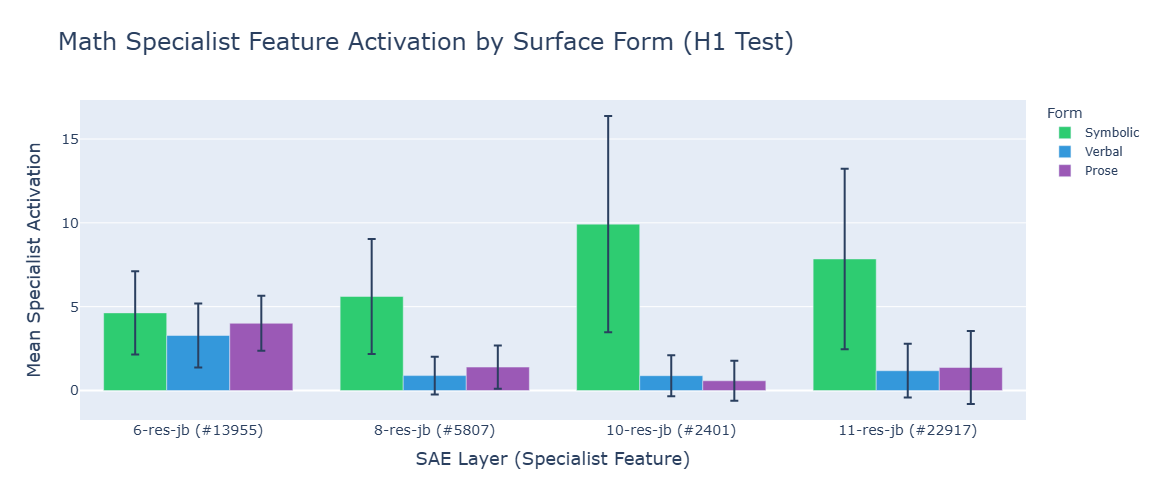

SAE Layer,Math Specialist Feature,Neuronpedia
6-res-jb,#13955,View on Neuronpedia
8-res-jb,#5807,View on Neuronpedia
10-res-jb,#2401,View on Neuronpedia
11-res-jb,#22917,View on Neuronpedia



4️⃣ Per-Pair Activation Comparison (Layer 11)...


,Pair,Expression,Symbolic Act.,Verbal Act.,Prose Act.,Sym > Verb,Sym > Prose
0,1,x^2 + 2x + 1,8.16,0.00,0.00,✅,✅
1,2,x^2 - 9,0.00,0.88,0.00,❌,❌
2,3,a^2 + b^2 = c^2,4.49,0.00,0.00,✅,✅
3,4,√(a^2 + b^2),7.66,0.09,1.44,✅,✅
4,5,E = mc^2,10.81,0.73,0.74,✅,✅
5,6,F = ma,0.00,0.11,3.62,❌,❌
6,7,sin^2(θ) + cos^2(θ) = 1,14.69,1.85,0.49,✅,✅
7,8,sin(2θ) = 2sin(θ)cos(θ),11.87,0.00,0.00,✅,✅
8,9,e^(iπ) + 1 = 0,7.90,0.00,0.00,✅,✅
9,10,ln(e^x) = x,3.79,0.00,0.00,✅,✅



5️⃣ Heatmap: Specialist Activation Across All Pairs and Forms...


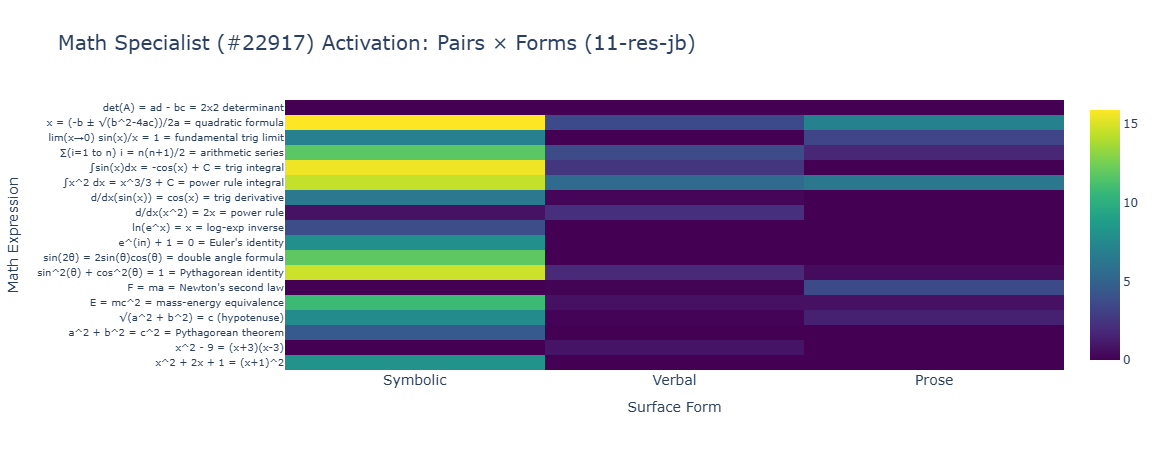


📊 HYPOTHESIS H1 ASSESSMENT

H1: Specialist features show higher activation for symbolic forms
    than verbal/prose forms of the same mathematical expression.

6-res-jb:
   Symbolic mean: 4.629
   Verbal mean:   3.280 (symbolic is 1.4x)
   Prose mean:    4.007 (symbolic is 1.2x)
   → ✅ H1 SUPPORTED for 6-res-jb

8-res-jb:
   Symbolic mean: 5.609
   Verbal mean:   0.888 (symbolic is 6.3x)
   Prose mean:    1.396 (symbolic is 4.0x)
   → ✅ H1 SUPPORTED for 8-res-jb

10-res-jb:
   Symbolic mean: 9.922
   Verbal mean:   0.881 (symbolic is 11.3x)
   Prose mean:    0.578 (symbolic is 17.2x)
   → ✅ H1 SUPPORTED for 10-res-jb

11-res-jb:
   Symbolic mean: 7.845
   Verbal mean:   1.178 (symbolic is 6.7x)
   Prose mean:    1.372 (symbolic is 5.7x)
   → ✅ H1 SUPPORTED for 11-res-jb


📈 OVERALL: H1 supported in 4/4 SAE layers
   → STRONG SUPPORT: Math specialist consistently activates more on symbolic notation



In [14]:
# ============================================================================
# CELL 15: Matched Pairs Analysis - Math Specialist Activation by Form (H1)
# ============================================================================
print("\n🔬 MATCHED PAIRS ANALYSIS: Math Specialist Activation by Form")
print("=" * 70)
print("""
Hypothesis H1: Specialist features will show significantly higher activation 
for symbolic forms than verbal/prose forms of the same mathematical expression.

Testing: Does the math specialist feature activate more strongly on "2+2" 
than on "two plus two" or "the sum of two and two"?
""")

# -----------------------------------------------------------------------------
# Step 1: Extract features for each form across all layers
# -----------------------------------------------------------------------------
print("\n1️⃣ Extracting features for matched pairs across all SAE layers...")

# Store results by SAE layer
form_activations_by_layer = {}

for sae_name in loaded_saes:
    print(f"\n   Processing {sae_name}...")
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    
    # Get the previously-identified math specialist feature for this layer
    math_specialist_idx = results['specialists'][sae_name]['Math']['feature_idx']
    math_specialist_score = results['specialists'][sae_name]['Math']['score']
    
    print(f"   Math specialist: Feature #{math_specialist_idx} (score: {math_specialist_score})")
    
    # Extract features for each form
    symbolic_features = extract_features(math_symbolic, sae_obj, hook_point)
    verbal_features = extract_features(math_verbal, sae_obj, hook_point)
    prose_features = extract_features(math_prose, sae_obj, hook_point)
    
    # Get specialist activation for each form
    symbolic_activations = symbolic_features[:, math_specialist_idx].detach().numpy()
    verbal_activations = verbal_features[:, math_specialist_idx].detach().numpy()
    prose_activations = prose_features[:, math_specialist_idx].detach().numpy()
    
    form_activations_by_layer[sae_name] = {
        'specialist_idx': math_specialist_idx,
        'specialist_score': math_specialist_score,
        'symbolic': symbolic_activations,
        'verbal': verbal_activations,
        'prose': prose_activations,
        'symbolic_mean': np.mean(symbolic_activations),
        'verbal_mean': np.mean(verbal_activations),
        'prose_mean': np.mean(prose_activations),
        'symbolic_std': np.std(symbolic_activations),
        'verbal_std': np.std(verbal_activations),
        'prose_std': np.std(prose_activations),
    }

print("\n   ✅ Feature extraction complete!")

# -----------------------------------------------------------------------------
# Step 2: Summary Statistics Table
# -----------------------------------------------------------------------------
print("\n2️⃣ Summary Statistics: Math Specialist Activation by Form")
print("=" * 70)

summary_data = []
for sae_name, data in form_activations_by_layer.items():
    summary_data.append({
        'SAE': sae_name,
        'Specialist': f"#{data['specialist_idx']}",
        'Symbolic Mean': f"{data['symbolic_mean']:.2f}",
        'Verbal Mean': f"{data['verbal_mean']:.2f}",
        'Prose Mean': f"{data['prose_mean']:.2f}",
        'Symbolic > Verbal': "✅" if data['symbolic_mean'] > data['verbal_mean'] else "❌",
        'Symbolic > Prose': "✅" if data['symbolic_mean'] > data['prose_mean'] else "❌",
    })

df_summary = pd.DataFrame(summary_data)
display(df_summary)


# -----------------------------------------------------------------------------
# Step 3: Grouped Bar Chart - Mean Activation by Form and Layer
# -----------------------------------------------------------------------------
print("\n3️⃣ Visualizing Mean Specialist Activation by Form...")

# Prepare data for plotting with combined labels
plot_data = []
for sae_name, data in form_activations_by_layer.items():
    # Create combined label: "11-res-jb (#22917)"
    label = f"{sae_name} (#{data['specialist_idx']})"
    plot_data.append({'SAE': label, 'Form': 'Symbolic', 'Mean Activation': data['symbolic_mean'], 'Std': data['symbolic_std']})
    plot_data.append({'SAE': label, 'Form': 'Verbal', 'Mean Activation': data['verbal_mean'], 'Std': data['verbal_std']})
    plot_data.append({'SAE': label, 'Form': 'Prose', 'Mean Activation': data['prose_mean'], 'Std': data['prose_std']})

df_plot = pd.DataFrame(plot_data)

fig = px.bar(
    df_plot,
    x='SAE',
    y='Mean Activation',
    color='Form',
    barmode='group',
    title='Math Specialist Feature Activation by Surface Form (H1 Test)',
    color_discrete_map={'Symbolic': '#2ecc71', 'Verbal': '#3498db', 'Prose': '#9b59b6'},
    error_y='Std'
)

fig.update_layout(
    title={'font': {'size': 24}},
    height=500,
    width=900,
    xaxis_title='SAE Layer (Specialist Feature)',
    yaxis_title='Mean Specialist Activation',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    legend_title_font={'size': 14},
    legend_font={'size': 12}
)

fig.show()

# Display table of specialist features with Neuronpedia links
specialist_table_html = """
<table style='border-collapse: collapse; margin: 10px 0;'>
<tr style='background-color: #f0f0f0;'>
<th style='padding: 8px; border: 1px solid #ddd;'>SAE Layer</th>
<th style='padding: 8px; border: 1px solid #ddd;'>Math Specialist Feature</th>
<th style='padding: 8px; border: 1px solid #ddd;'>Neuronpedia</th>
</tr>
"""

for sae_name, data in form_activations_by_layer.items():
    feat_idx = data['specialist_idx']
    url = f"https://neuronpedia.org/gpt2-small/{sae_name}/{feat_idx}"
    specialist_table_html += f"""
<tr>
<td style='padding: 8px; border: 1px solid #ddd;'>{sae_name}</td>
<td style='padding: 8px; border: 1px solid #ddd;'>#{feat_idx}</td>
<td style='padding: 8px; border: 1px solid #ddd;'><a href='{url}' target='_blank'>View on Neuronpedia</a></td>
</tr>
"""

specialist_table_html += "</table>"

from IPython.display import HTML
display(HTML(specialist_table_html))


# -----------------------------------------------------------------------------
# Step 4: Per-Pair Comparison (Detailed View)
# -----------------------------------------------------------------------------
print("\n4️⃣ Per-Pair Activation Comparison (Layer 11)...")

# Use layer 11 for detailed analysis
analysis_sae = "11-res-jb"
data = form_activations_by_layer[analysis_sae]

# Create detailed per-pair dataframe
pair_details = []
for i, pair in enumerate(math_pairs):
    pair_details.append({
        'Pair': i + 1,
        'Expression': pair['symbolic'],
        'Symbolic Act.': f"{data['symbolic'][i]:.2f}",
        'Verbal Act.': f"{data['verbal'][i]:.2f}",
        'Prose Act.': f"{data['prose'][i]:.2f}",
        'Sym > Verb': "✅" if data['symbolic'][i] > data['verbal'][i] else "❌",
        'Sym > Prose': "✅" if data['symbolic'][i] > data['prose'][i] else "❌",
    })

df_pairs = pd.DataFrame(pair_details)

# Display styled title
from IPython.display import HTML
neuronpedia_url = f"https://neuronpedia.org/gpt2-small/{analysis_sae}/{data['specialist_idx']}"
display(HTML(f"""
<h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    Per-Pair Activation Comparison ({analysis_sae}) — Math Specialist 
    <a href='{neuronpedia_url}' target='_blank'>#{data['specialist_idx']}</a>
</h3>
"""))

display(df_pairs)


# -----------------------------------------------------------------------------
# Step 5: Heatmap - All Pairs × Forms
# -----------------------------------------------------------------------------
print("\n5️⃣ Heatmap: Specialist Activation Across All Pairs and Forms...")

# Create matrix [pairs × forms]
activation_matrix = np.column_stack([
    data['symbolic'],
    data['verbal'],
    data['prose']
])

# Create pair labels
pair_labels = [f"{p['symbolic']} = {p['expected']}" for p in math_pairs]

fig_heatmap = go.Figure(data=go.Heatmap(
    z=activation_matrix,
    x=['Symbolic', 'Verbal', 'Prose'],
    y=pair_labels,
    colorscale='Viridis',
    hovertemplate='Pair: %{y}<br>Form: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig_heatmap.update_layout(
    title={
        'text': f'Math Specialist (#{data["specialist_idx"]}) Activation: Pairs × Forms ({analysis_sae})',
        'font': {'size': 20}
    },
    xaxis_title='Surface Form',
    yaxis_title='Math Expression',
    height=max(400, len(math_pairs) * 25),
    width=600,
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 10}
)

fig_heatmap.show()

# -----------------------------------------------------------------------------
# Step 6: Statistical Summary & H1 Assessment
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 HYPOTHESIS H1 ASSESSMENT")
print("=" * 70)

print("\nH1: Specialist features show higher activation for symbolic forms")
print("    than verbal/prose forms of the same mathematical expression.\n")

for sae_name, data in form_activations_by_layer.items():
    sym_mean = data['symbolic_mean']
    verb_mean = data['verbal_mean']
    prose_mean = data['prose_mean']
    
    # Calculate ratios
    sym_verb_ratio = sym_mean / verb_mean if verb_mean > 0 else float('inf')
    sym_prose_ratio = sym_mean / prose_mean if prose_mean > 0 else float('inf')
    
    print(f"{sae_name}:")
    print(f"   Symbolic mean: {sym_mean:.3f}")
    print(f"   Verbal mean:   {verb_mean:.3f} (symbolic is {sym_verb_ratio:.1f}x)")
    print(f"   Prose mean:    {prose_mean:.3f} (symbolic is {sym_prose_ratio:.1f}x)")
    
    if sym_mean > verb_mean and sym_mean > prose_mean:
        print(f"   → ✅ H1 SUPPORTED for {sae_name}")
    else:
        print(f"   → ❌ H1 NOT SUPPORTED for {sae_name}")
    print()

# Overall assessment
layers_supporting_h1 = sum(1 for data in form_activations_by_layer.values() 
                           if data['symbolic_mean'] > data['verbal_mean'] 
                           and data['symbolic_mean'] > data['prose_mean'])

print(f"\n📈 OVERALL: H1 supported in {layers_supporting_h1}/{len(form_activations_by_layer)} SAE layers")

if layers_supporting_h1 == len(form_activations_by_layer):
    print("   → STRONG SUPPORT: Math specialist consistently activates more on symbolic notation")
elif layers_supporting_h1 > len(form_activations_by_layer) / 2:
    print("   → PARTIAL SUPPORT: Math specialist shows preference for symbolic form in most layers")
else:
    print("   → WEAK/NO SUPPORT: Math specialist does not consistently prefer symbolic form")

print("\n" + "=" * 70)


🔬 FEATURE COMPARISON ACROSS SURFACE FORMS

Question: Do different surface forms activate different features?

If symbolic, verbal, and prose forms of the same math concepts activate 
largely distinct feature sets, this supports the conclusion that GPT-2's
representations are organized by surface syntax rather than semantic meaning.

1️⃣ Extracting top 20 features for each surface form...

   Processing 6-res-jb...

   Processing 8-res-jb...

   Processing 10-res-jb...

   Processing 11-res-jb...

   ✅ Feature extraction complete!

2️⃣ Computing feature overlap between surface forms...

6-res-jb:
   Symbolic ∩ Verbal:  11 features (55%)
   Symbolic ∩ Prose:    7 features (35%)
   Verbal ∩ Prose:     13 features (65%)
   All three:           7 features (35%)
   ---
   Symbolic only:       9 features (45%)
   Verbal only:         3 features (15%)
   Prose only:          7 features (35%)

8-res-jb:
   Symbolic ∩ Verbal:   9 features (45%)
   Symbolic ∩ Prose:    9 features (45%)
   Verbal

,SAE,Sym∩Verb,Sym∩Prose,Verb∩Prose,All Three,Sym Only,Verb Only,Prose Only
0,6-res-jb,11,7,13,7,9,3,7
1,8-res-jb,9,9,12,7,9,6,6
2,10-res-jb,10,10,13,9,9,6,6
3,11-res-jb,8,6,12,6,12,6,8



4️⃣ Visualizing feature overlap patterns...


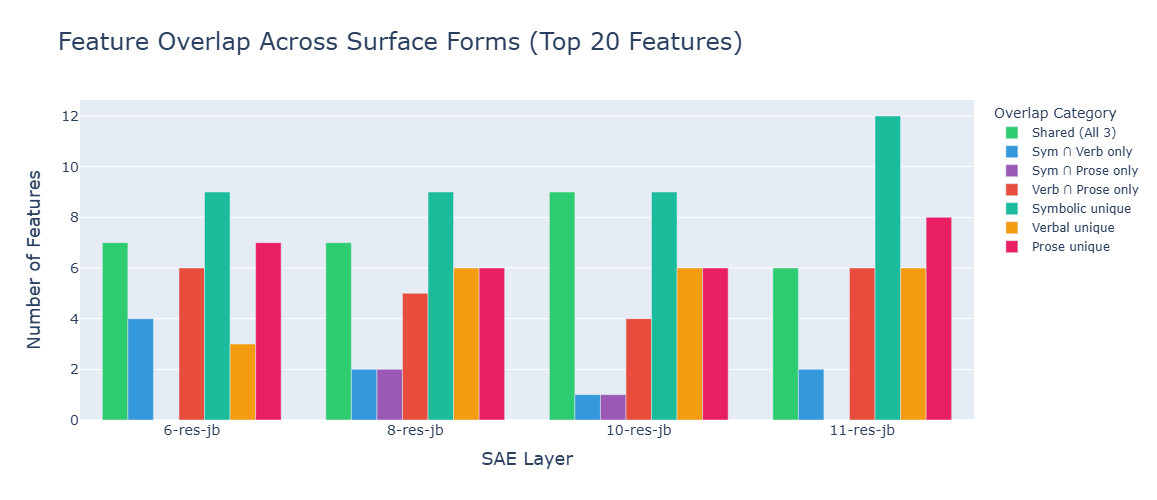


5️⃣ Deep Dive: Feature activation heatmap for 11-res-jb...


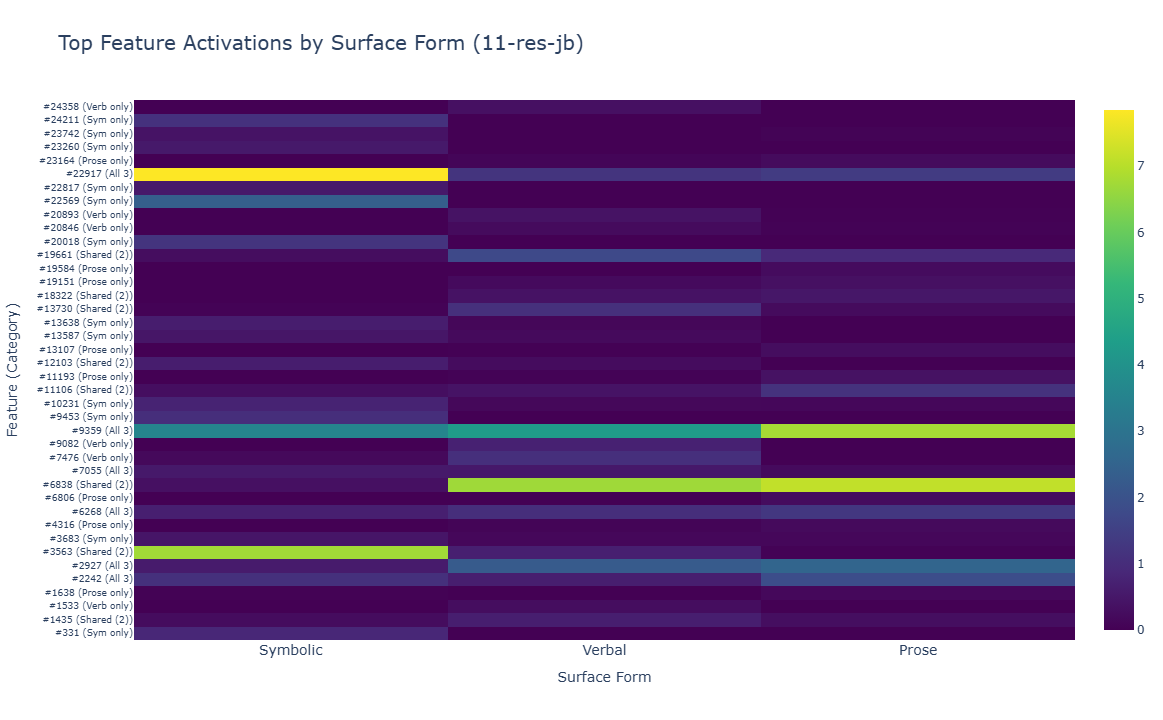


6️⃣ Feature Lists for 11-res-jb (with Neuronpedia links)

📊 SYMBOLIC form top features:


Rank,Feature,Activation,Neuronpedia
1,#22917,7.85,View
2,#3563,6.74,View
3,#9359,3.58,View
4,#22569,2.35,View
5,#20018,1.18,View
6,#24211,1.11,View
7,#2242,1.09,View
8,#9453,1.04,View
9,#331,0.85,View
10,#10231,0.76,View



📊 VERBAL form top features:


Rank,Feature,Activation,Neuronpedia
1,#6838,6.70,View
2,#9359,4.28,View
3,#2927,2.24,View
4,#19661,1.74,View
5,#22917,1.18,View
6,#13730,1.09,View
7,#7476,1.06,View
8,#6268,1.02,View
9,#9082,0.72,View
10,#3563,0.67,View



📊 PROSE form top features:


Rank,Feature,Activation,Neuronpedia
1,#6838,7.12,View
2,#9359,6.78,View
3,#2927,2.52,View
4,#2242,1.87,View
5,#22917,1.37,View
6,#6268,1.27,View
7,#11106,1.15,View
8,#19661,0.91,View
9,#18322,0.50,View
10,#11193,0.37,View



📊 INTERPRETATION SUMMARY

Across all 4 SAE layers (top 20 features):

   THREE-WAY OVERLAP:
   • Average features shared by ALL forms: 7.2 (36%)

   PAIRWISE OVERLAPS:
   • Symbolic ∩ Verbal:  9.5 (48%)
   • Symbolic ∩ Prose:   8.0 (40%)
   • Verbal ∩ Prose:     12.5 (62%)

   UNIQUE FEATURES:
   • Average features unique to Symbolic:  9.8 (49%)
   • Average features unique to Verbal:    5.2 (26%)
   • Average features unique to Prose:     6.8 (34%)

📌 KEY FINDINGS:

   1. MIXED REPRESENTATION:
      The moderate three-way overlap suggests a MIXED representation -
      some features respond to syntax/surface form, while others may
      capture semantic content.

   2. PAIRWISE OVERLAP PATTERN:
      Verbal ∩ Prose (12%) > Symbolic ∩ Verbal (10%) ≈ Symbolic ∩ Prose (8%)
      
      This pattern makes intuitive sense: verbal and prose forms are both
      NATURAL LANGUAGE - they share English vocabulary, word structure,
      and grammatical patterns. Symbolic notation uses a fundame

In [15]:
# ============================================================================
# CELL 16: Feature Comparison Across Surface Forms
# ============================================================================
print("\n🔬 FEATURE COMPARISON ACROSS SURFACE FORMS")
print("=" * 70)
print("""
Question: Do different surface forms activate different features?

If symbolic, verbal, and prose forms of the same math concepts activate 
largely distinct feature sets, this supports the conclusion that GPT-2's
representations are organized by surface syntax rather than semantic meaning.
""")

# -----------------------------------------------------------------------------
# Step 1: Extract top-N features for each form at each layer
# -----------------------------------------------------------------------------
TOP_N = 20  # Number of top features to compare

print(f"1️⃣ Extracting top {TOP_N} features for each surface form...")

form_features_by_layer = {}

for sae_name in loaded_saes:
    print(f"\n   Processing {sae_name}...")
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    
    # Extract features for each form
    symbolic_features = extract_features(math_symbolic, sae_obj, hook_point)
    verbal_features = extract_features(math_verbal, sae_obj, hook_point)
    prose_features = extract_features(math_prose, sae_obj, hook_point)
    
    # Get mean activation across all texts for each feature
    symbolic_mean = symbolic_features.mean(dim=0).detach().numpy()
    verbal_mean = verbal_features.mean(dim=0).detach().numpy()
    prose_mean = prose_features.mean(dim=0).detach().numpy()
    
    # Get top-N feature indices for each form
    symbolic_top_idx = np.argsort(symbolic_mean)[-TOP_N:][::-1]
    verbal_top_idx = np.argsort(verbal_mean)[-TOP_N:][::-1]
    prose_top_idx = np.argsort(prose_mean)[-TOP_N:][::-1]
    
    # Store results
    form_features_by_layer[sae_name] = {
        'symbolic': {
            'top_indices': symbolic_top_idx,
            'top_values': symbolic_mean[symbolic_top_idx],
            'all_means': symbolic_mean
        },
        'verbal': {
            'top_indices': verbal_top_idx,
            'top_values': verbal_mean[verbal_top_idx],
            'all_means': verbal_mean
        },
        'prose': {
            'top_indices': prose_top_idx,
            'top_values': prose_mean[prose_top_idx],
            'all_means': prose_mean
        }
    }

print("\n   ✅ Feature extraction complete!")

# -----------------------------------------------------------------------------
# Step 2: Compute Overlap Statistics
# -----------------------------------------------------------------------------
print(f"\n2️⃣ Computing feature overlap between surface forms...")
print("=" * 70)

overlap_stats = {}

for sae_name, data in form_features_by_layer.items():
    sym_set = set(data['symbolic']['top_indices'])
    verb_set = set(data['verbal']['top_indices'])
    prose_set = set(data['prose']['top_indices'])
    
    # Pairwise overlaps
    sym_verb = sym_set & verb_set
    sym_prose = sym_set & prose_set
    verb_prose = verb_set & prose_set
    
    # Three-way overlap
    all_three = sym_set & verb_set & prose_set
    
    # Unique to each form
    sym_only = sym_set - verb_set - prose_set
    verb_only = verb_set - sym_set - prose_set
    prose_only = prose_set - sym_set - verb_set
    
    overlap_stats[sae_name] = {
        'sym_verb': sym_verb,
        'sym_prose': sym_prose,
        'verb_prose': verb_prose,
        'all_three': all_three,
        'sym_only': sym_only,
        'verb_only': verb_only,
        'prose_only': prose_only,
        'sets': {'symbolic': sym_set, 'verbal': verb_set, 'prose': prose_set}
    }
    
    print(f"\n{sae_name}:")
    print(f"   Symbolic ∩ Verbal:  {len(sym_verb):2d} features ({len(sym_verb)/TOP_N*100:.0f}%)")
    print(f"   Symbolic ∩ Prose:   {len(sym_prose):2d} features ({len(sym_prose)/TOP_N*100:.0f}%)")
    print(f"   Verbal ∩ Prose:     {len(verb_prose):2d} features ({len(verb_prose)/TOP_N*100:.0f}%)")
    print(f"   All three:          {len(all_three):2d} features ({len(all_three)/TOP_N*100:.0f}%)")
    print(f"   ---")
    print(f"   Symbolic only:      {len(sym_only):2d} features ({len(sym_only)/TOP_N*100:.0f}%)")
    print(f"   Verbal only:        {len(verb_only):2d} features ({len(verb_only)/TOP_N*100:.0f}%)")
    print(f"   Prose only:         {len(prose_only):2d} features ({len(prose_only)/TOP_N*100:.0f}%)")

# -----------------------------------------------------------------------------
# Step 3: Summary Table
# -----------------------------------------------------------------------------
print(f"\n3️⃣ Overlap Summary Table")
print("=" * 70)

summary_rows = []
for sae_name, stats in overlap_stats.items():
    summary_rows.append({
        'SAE': sae_name,
        'Sym∩Verb': len(stats['sym_verb']),
        'Sym∩Prose': len(stats['sym_prose']),
        'Verb∩Prose': len(stats['verb_prose']),
        'All Three': len(stats['all_three']),
        'Sym Only': len(stats['sym_only']),
        'Verb Only': len(stats['verb_only']),
        'Prose Only': len(stats['prose_only']),
    })

df_overlap = pd.DataFrame(summary_rows)
display(df_overlap)

# -----------------------------------------------------------------------------
# Step 4: Visualization - Grouped Bar Chart of Overlap
# -----------------------------------------------------------------------------
print(f"\n4️⃣ Visualizing feature overlap patterns...")

# Prepare data for grouped bar chart
bar_data = []
for sae_name, stats in overlap_stats.items():
    bar_data.append({'SAE': sae_name, 'Category': 'Shared (All 3)', 'Count': len(stats['all_three'])})
    bar_data.append({'SAE': sae_name, 'Category': 'Sym ∩ Verb only', 'Count': len(stats['sym_verb'] - stats['all_three'])})
    bar_data.append({'SAE': sae_name, 'Category': 'Sym ∩ Prose only', 'Count': len(stats['sym_prose'] - stats['all_three'])})
    bar_data.append({'SAE': sae_name, 'Category': 'Verb ∩ Prose only', 'Count': len(stats['verb_prose'] - stats['all_three'])})
    bar_data.append({'SAE': sae_name, 'Category': 'Symbolic unique', 'Count': len(stats['sym_only'])})
    bar_data.append({'SAE': sae_name, 'Category': 'Verbal unique', 'Count': len(stats['verb_only'])})
    bar_data.append({'SAE': sae_name, 'Category': 'Prose unique', 'Count': len(stats['prose_only'])})

df_bar = pd.DataFrame(bar_data)

fig_overlap = px.bar(
    df_bar,
    x='SAE',
    y='Count',
    color='Category',
    barmode='group',
    title=f'Feature Overlap Across Surface Forms (Top {TOP_N} Features)',
    color_discrete_map={
        'Shared (All 3)': '#2ecc71',
        'Sym ∩ Verb only': '#3498db',
        'Sym ∩ Prose only': '#9b59b6',
        'Verb ∩ Prose only': '#e74c3c',
        'Symbolic unique': '#1abc9c',
        'Verbal unique': '#f39c12',
        'Prose unique': '#e91e63'
    }
)

fig_overlap.update_layout(
    title={'font': {'size': 24}},
    height=500,
    width=1000,
    xaxis_title='SAE Layer',
    yaxis_title='Number of Features',
    xaxis_title_font={'size': 18},
    yaxis_title_font={'size': 18},
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 14},
    legend_title_text='Overlap Category'
)

fig_overlap.show()

# -----------------------------------------------------------------------------
# Step 5: Heatmap - Feature Activation Comparison (Single Layer Deep Dive)
# -----------------------------------------------------------------------------
print(f"\n5️⃣ Deep Dive: Feature activation heatmap for {analysis_sae}...")

analysis_data = form_features_by_layer[analysis_sae]
analysis_overlap = overlap_stats[analysis_sae]

# Collect all unique features from all three forms
all_top_features = sorted(
    analysis_overlap['sets']['symbolic'] | 
    analysis_overlap['sets']['verbal'] | 
    analysis_overlap['sets']['prose']
)

# Build activation matrix: features × forms
heatmap_matrix = []
feature_labels = []
feature_categories = []

for feat_idx in all_top_features:
    sym_act = analysis_data['symbolic']['all_means'][feat_idx]
    verb_act = analysis_data['verbal']['all_means'][feat_idx]
    prose_act = analysis_data['prose']['all_means'][feat_idx]
    heatmap_matrix.append([sym_act, verb_act, prose_act])
    feature_labels.append(f"#{feat_idx}")
    
    # Categorize feature
    in_sym = feat_idx in analysis_overlap['sets']['symbolic']
    in_verb = feat_idx in analysis_overlap['sets']['verbal']
    in_prose = feat_idx in analysis_overlap['sets']['prose']
    
    if in_sym and in_verb and in_prose:
        feature_categories.append("All 3")
    elif in_sym and not in_verb and not in_prose:
        feature_categories.append("Sym only")
    elif in_verb and not in_sym and not in_prose:
        feature_categories.append("Verb only")
    elif in_prose and not in_sym and not in_verb:
        feature_categories.append("Prose only")
    else:
        feature_categories.append("Shared (2)")

heatmap_matrix = np.array(heatmap_matrix)

# Create heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
    z=heatmap_matrix,
    x=['Symbolic', 'Verbal', 'Prose'],
    y=[f"{lbl} ({cat})" for lbl, cat in zip(feature_labels, feature_categories)],
    colorscale='Viridis',
    hovertemplate='Feature: %{y}<br>Form: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig_heatmap.update_layout(
    title={
        'text': f'Top Feature Activations by Surface Form ({analysis_sae})',
        'font': {'size': 20}
    },
    xaxis_title='Surface Form',
    yaxis_title='Feature (Category)',
    height=max(600, len(all_top_features) * 18),
    width=700,
    xaxis_tickfont={'size': 14},
    yaxis_tickfont={'size': 9}
)

fig_heatmap.show()

# -----------------------------------------------------------------------------
# Step 6: Detailed Feature Lists with Neuronpedia Links
# -----------------------------------------------------------------------------
print(f"\n6️⃣ Feature Lists for {analysis_sae} (with Neuronpedia links)")
print("=" * 70)

def create_feature_table(feature_indices, activations, form_name, sae_name):
    """Create HTML table for features with Neuronpedia links."""
    html = f"<h4>Top {len(feature_indices)} {form_name} Features ({sae_name})</h4>"
    html += "<table style='border-collapse: collapse; margin: 10px 0;'>"
    html += "<tr style='background-color: #f0f0f0;'>"
    html += "<th style='padding: 8px; border: 1px solid #ddd;'>Rank</th>"
    html += "<th style='padding: 8px; border: 1px solid #ddd;'>Feature</th>"
    html += "<th style='padding: 8px; border: 1px solid #ddd;'>Activation</th>"
    html += "<th style='padding: 8px; border: 1px solid #ddd;'>Neuronpedia</th>"
    html += "</tr>"
    
    for rank, (idx, val) in enumerate(zip(feature_indices, activations), 1):
        url = f"https://neuronpedia.org/gpt2-small/{sae_name}/{idx}"
        html += f"<tr>"
        html += f"<td style='padding: 8px; border: 1px solid #ddd;'>{rank}</td>"
        html += f"<td style='padding: 8px; border: 1px solid #ddd;'>#{idx}</td>"
        html += f"<td style='padding: 8px; border: 1px solid #ddd;'>{val:.2f}</td>"
        html += f"<td style='padding: 8px; border: 1px solid #ddd;'><a href='{url}' target='_blank'>View</a></td>"
        html += "</tr>"
    
    html += "</table>"
    return html

# Display tables for each form
from IPython.display import HTML

print("\n📊 SYMBOLIC form top features:")
display(HTML(create_feature_table(
    analysis_data['symbolic']['top_indices'][:10],
    analysis_data['symbolic']['top_values'][:10],
    'Symbolic', analysis_sae
)))

print("\n📊 VERBAL form top features:")
display(HTML(create_feature_table(
    analysis_data['verbal']['top_indices'][:10],
    analysis_data['verbal']['top_values'][:10],
    'Verbal', analysis_sae
)))

print("\n📊 PROSE form top features:")
display(HTML(create_feature_table(
    analysis_data['prose']['top_indices'][:10],
    analysis_data['prose']['top_values'][:10],
    'Prose', analysis_sae
)))

# -----------------------------------------------------------------------------
# Step 7: Interpretation Summary
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 INTERPRETATION SUMMARY")
print("=" * 70)

# Calculate average overlap percentages across layers
avg_all_three = np.mean([len(s['all_three']) for s in overlap_stats.values()])
avg_sym_only = np.mean([len(s['sym_only']) for s in overlap_stats.values()])
avg_verb_only = np.mean([len(s['verb_only']) for s in overlap_stats.values()])
avg_prose_only = np.mean([len(s['prose_only']) for s in overlap_stats.values()])

# Calculate average pairwise overlaps
avg_sym_verb = np.mean([len(s['sym_verb']) for s in overlap_stats.values()])
avg_sym_prose = np.mean([len(s['sym_prose']) for s in overlap_stats.values()])
avg_verb_prose = np.mean([len(s['verb_prose']) for s in overlap_stats.values()])

print(f"\nAcross all {len(loaded_saes)} SAE layers (top {TOP_N} features):")
print(f"\n   THREE-WAY OVERLAP:")
print(f"   • Average features shared by ALL forms: {avg_all_three:.1f} ({avg_all_three/TOP_N*100:.0f}%)")

print(f"\n   PAIRWISE OVERLAPS:")
print(f"   • Symbolic ∩ Verbal:  {avg_sym_verb:.1f} ({avg_sym_verb/TOP_N*100:.0f}%)")
print(f"   • Symbolic ∩ Prose:   {avg_sym_prose:.1f} ({avg_sym_prose/TOP_N*100:.0f}%)")
print(f"   • Verbal ∩ Prose:     {avg_verb_prose:.1f} ({avg_verb_prose/TOP_N*100:.0f}%)")

print(f"\n   UNIQUE FEATURES:")
print(f"   • Average features unique to Symbolic:  {avg_sym_only:.1f} ({avg_sym_only/TOP_N*100:.0f}%)")
print(f"   • Average features unique to Verbal:    {avg_verb_only:.1f} ({avg_verb_only/TOP_N*100:.0f}%)")
print(f"   • Average features unique to Prose:     {avg_prose_only:.1f} ({avg_prose_only/TOP_N*100:.0f}%)")

print("\n📌 KEY FINDINGS:")

# Finding 1: Overall overlap assessment
if avg_all_three < TOP_N * 0.25:
    print("\n   1. LOW SEMANTIC OVERLAP:")
    print("      The low three-way overlap suggests that GPT-2's representations")
    print("      are organized primarily by SYNTAX, not SEMANTICS. Different surface")
    print("      forms of the same mathematical concept activate largely distinct")
    print("      feature sets.")
elif avg_all_three > TOP_N * 0.5:
    print("\n   1. HIGH SEMANTIC OVERLAP:")
    print("      The high three-way overlap suggests some degree of SEMANTIC")
    print("      abstraction - GPT-2 may recognize mathematical concepts")
    print("      independent of their surface form.")
else:
    print("\n   1. MIXED REPRESENTATION:")
    print("      The moderate three-way overlap suggests a MIXED representation -")
    print("      some features respond to syntax/surface form, while others may")
    print("      capture semantic content.")

# Finding 2: Pairwise overlap patterns
print("\n   2. PAIRWISE OVERLAP PATTERN:")
if avg_verb_prose > avg_sym_verb and avg_verb_prose > avg_sym_prose:
    print(f"      Verbal ∩ Prose ({avg_verb_prose:.0f}%) > Symbolic ∩ Verbal ({avg_sym_verb:.0f}%) ≈ Symbolic ∩ Prose ({avg_sym_prose:.0f}%)")
    print("      ")
    print("      This pattern makes intuitive sense: verbal and prose forms are both")
    print("      NATURAL LANGUAGE - they share English vocabulary, word structure,")
    print("      and grammatical patterns. Symbolic notation uses a fundamentally")
    print("      different character set (digits, operators, Greek letters).")
    print("      ")
    print("      This suggests GPT-2 has distinct feature populations for:")
    print("        • 'Mathematical notation' (activated by symbolic forms)")
    print("        • 'Natural language about math' (activated by verbal & prose)")
elif avg_sym_verb > avg_verb_prose and avg_sym_verb > avg_sym_prose:
    print(f"      Symbolic ∩ Verbal ({avg_sym_verb:.0f}%) shows highest overlap")
    print("      This suggests verbal descriptions may share features with symbolic notation.")
else:
    print(f"      Symbolic ∩ Prose ({avg_sym_prose:.0f}%) shows highest overlap")
    print("      This is an unexpected pattern worth further investigation.")

# Finding 3: Symbolic uniqueness
print("\n   3. SYMBOLIC UNIQUENESS:")
print(f"      Symbolic forms have the highest proportion of unique features ({avg_sym_only:.0f}%),")
print("      reinforcing that mathematical notation activates a distinct set of")
print("      features not triggered by natural language descriptions of the same concepts.")

print("\n" + "=" * 70)


🔬 COSINE SIMILARITY ANALYSIS: Form vs. Concept Clustering (H3)

Hypothesis H3: Activation vectors will cluster by surface form rather than 
by concept. That is, "x^2 + 2x + 1" will be more similar to "sin^2(θ) + cos^2(θ) = 1"
(same form, different concept) than to "x squared plus two x plus one" 
(same concept, different form).

If H3 is supported: Surface form dominates internal representation.
If H3 is not supported: The model achieves some form-invariant conceptual understanding.

1️⃣ Extracting full activation vectors for all matched pairs...
   Extracted 18 pairs × 24576 features
   Layer: 11-res-jb

2️⃣ Computing within-concept similarities (same concept, different form)...
   Mean within-concept similarity: 0.397

3️⃣ Computing within-form similarities (same form, different concept)...
   Mean within-form similarity (Symbolic): 0.542
   Mean within-form similarity (Verbal):   0.472
   Mean within-form similarity (Prose):    0.576
   Overall within-form mean:               0.530

,Comparison Type,Mean Similarity,Category
0,Within-Concept (Sym↔Verb),0.255546,Same Concept
1,Within-Concept (Sym↔Prose),0.212783,Same Concept
2,Within-Concept (Verb↔Prose),0.723772,Same Concept
3,Within-Form (Symbolic),0.541627,Same Form
4,Within-Form (Verbal),0.471810,Same Form
5,Within-Form (Prose),0.575826,Same Form



5️⃣ Visualizing similarity comparisons...


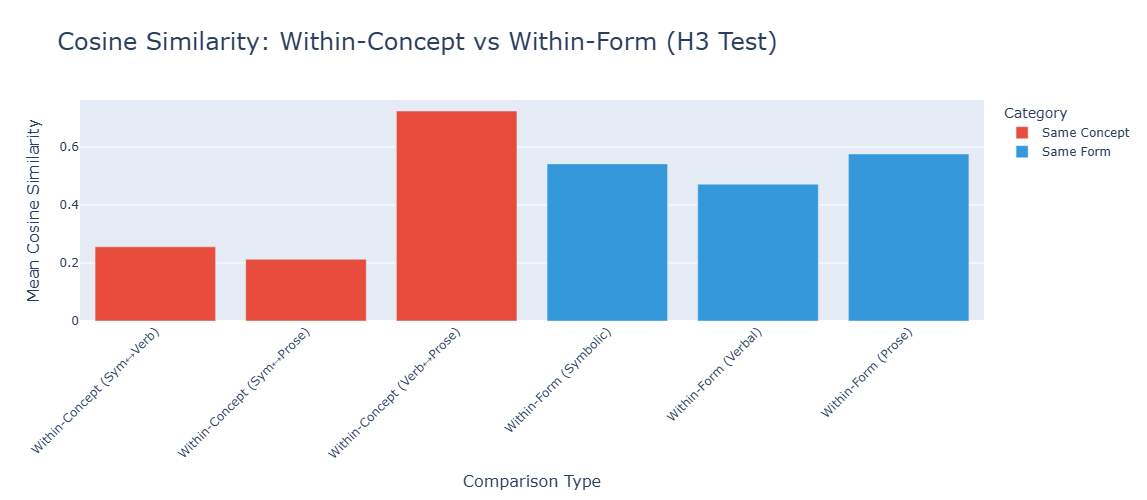


6️⃣ Generating full similarity heatmap...


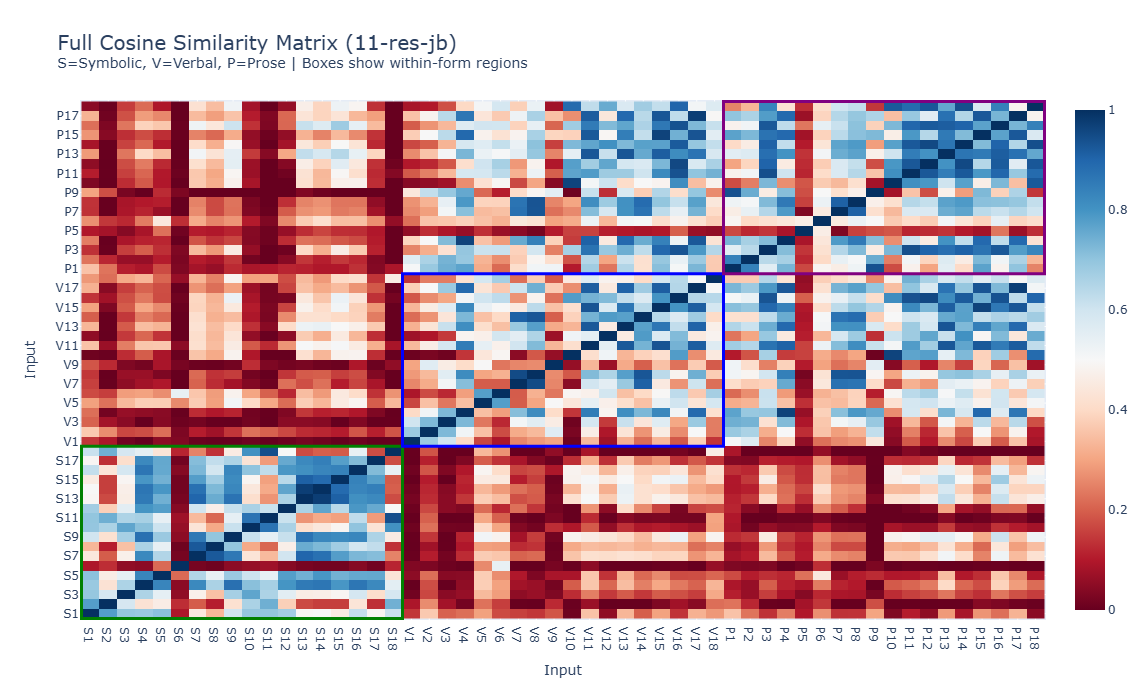


7️⃣ Analyzing matched pair similarities (diagonal patterns)...


,Pair,Expression,Symbolic↔Verbose,Symbolic↔Prose,Verbose↔Prose
0,1,x^2 + 2x + 1,0.141628,0.354571,0.505892
1,2,x^2 - 9,0.264125,0.119989,0.659926
2,3,a^2 + b^2 = c^2,0.046411,0.153100,0.422789
3,4,√(a^2 + b^2),0.053345,0.113029,0.965571
4,5,E = mc^2,0.374620,0.224574,0.132458
5,6,F = ma,0.540203,0.130354,0.324334
6,7,sin^2(θ) + cos^2(θ) = 1,0.204391,0.262679,0.876447
7,8,sin(2θ) = 2sin(θ)cos(θ),0.135699,0.168784,0.933015
8,9,e^(iπ) + 1 = 0,0.015824,0.000000,0.552940
9,10,ln(e^x) = x,0.095425,0.085560,0.962770



📊 HYPOTHESIS H3 ASSESSMENT

H3: Activation vectors cluster by surface form rather than by concept.
    Test: Is within-form similarity > within-concept similarity?

Within-CONCEPT similarity (same concept, different form):
   Mean: 0.3974 ± 0.3092
   N = 54 comparisons

Within-FORM similarity (same form, different concept):
   Mean: 0.5298 ± 0.2519
   N = 459 comparisons

Difference: 0.1324
Ratio: 1.33x

Statistical test (independent t-test):
   t-statistic: 3.552
   p-value: 4.18e-04

📌 CONCLUSION:
   ✅ H3 SUPPORTED
   Within-form similarity (0.530) > Within-concept similarity (0.397)
   Representations cluster by SURFACE FORM, not by semantic concept.
   This confirms that GPT-2's internal representations prioritize syntax over semantics.

8️⃣ Visualizing similarity distributions...


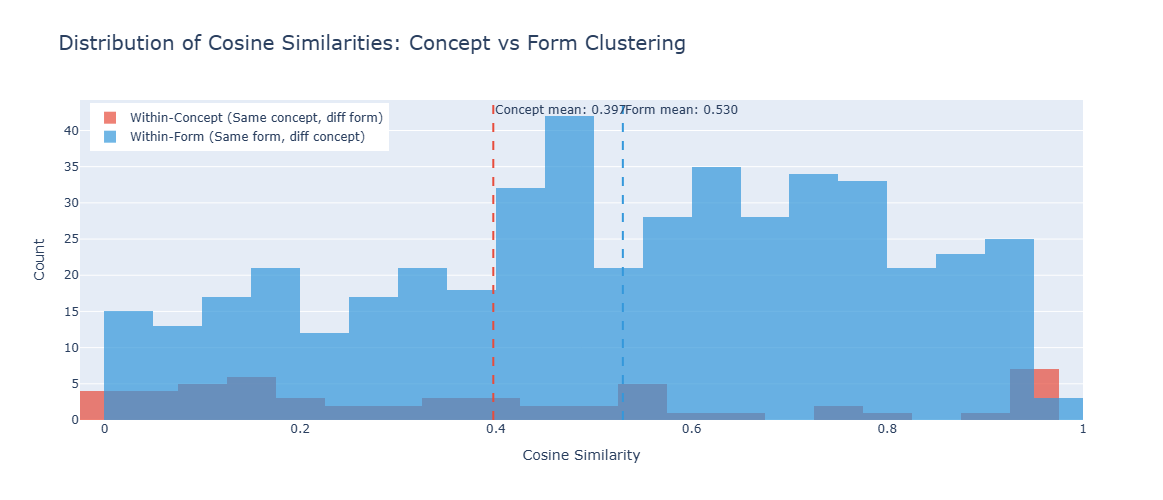

In [16]:
# ============================================================================
# CELL 17: Cosine Similarity Analysis (H3 - Representational Clustering)
# ============================================================================
print("\n🔬 COSINE SIMILARITY ANALYSIS: Form vs. Concept Clustering (H3)")
print("=" * 70)
print("""
Hypothesis H3: Activation vectors will cluster by surface form rather than 
by concept. That is, "x^2 + 2x + 1" will be more similar to "sin^2(θ) + cos^2(θ) = 1"
(same form, different concept) than to "x squared plus two x plus one" 
(same concept, different form).

If H3 is supported: Surface form dominates internal representation.
If H3 is not supported: The model achieves some form-invariant conceptual understanding.
""")

from scipy.spatial.distance import cosine
import torch.nn.functional as F

# -----------------------------------------------------------------------------
# Step 1: Extract Full Activation Vectors for All Forms
# -----------------------------------------------------------------------------
print("1️⃣ Extracting full activation vectors for all matched pairs...")

# We'll use layer 11 for this analysis (best specialist layer)
analysis_sae = "11-res-jb"
sae_obj = loaded_saes[analysis_sae]['sae']
hook_point = loaded_saes[analysis_sae]['config']['hook_point']

# Extract full feature vectors (not just specialist features)
symbolic_vectors = extract_features(math_symbolic, sae_obj, hook_point).detach().numpy()
verbal_vectors = extract_features(math_verbal, sae_obj, hook_point).detach().numpy()
prose_vectors = extract_features(math_prose, sae_obj, hook_point).detach().numpy()

print(f"   Extracted {symbolic_vectors.shape[0]} pairs × {symbolic_vectors.shape[1]} features")
print(f"   Layer: {analysis_sae}")

# -----------------------------------------------------------------------------
# Step 2: Compute Cosine Similarity Function
# -----------------------------------------------------------------------------
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot_product / (norm1 * norm2)

# -----------------------------------------------------------------------------
# Step 3: Compute Within-Concept Similarities (Same Concept, Different Form)
# -----------------------------------------------------------------------------
print("\n2️⃣ Computing within-concept similarities (same concept, different form)...")

within_concept_similarities = []

for i in range(len(math_pairs)):
    sym_vec = symbolic_vectors[i]
    verb_vec = verbal_vectors[i]
    prose_vec = prose_vectors[i]
    
    # Similarities between different forms of the SAME concept
    sym_verb_sim = cosine_similarity(sym_vec, verb_vec)
    sym_prose_sim = cosine_similarity(sym_vec, prose_vec)
    verb_prose_sim = cosine_similarity(verb_vec, prose_vec)
    
    within_concept_similarities.append({
        'pair_idx': i,
        'expression': math_pairs[i]['symbolic'],
        'sym_verb': sym_verb_sim,
        'sym_prose': sym_prose_sim,
        'verb_prose': verb_prose_sim,
        'mean': np.mean([sym_verb_sim, sym_prose_sim, verb_prose_sim])
    })

df_within = pd.DataFrame(within_concept_similarities)
print(f"   Mean within-concept similarity: {df_within['mean'].mean():.3f}")

# -----------------------------------------------------------------------------
# Step 4: Compute Within-Form Similarities (Same Form, Different Concept)
# -----------------------------------------------------------------------------
print("\n3️⃣ Computing within-form similarities (same form, different concept)...")

within_form_similarities = {
    'symbolic': [],
    'verbal': [],
    'prose': []
}

# For each form, compute pairwise similarities between ALL pairs (different concepts)
for i in range(len(math_pairs)):
    for j in range(i + 1, len(math_pairs)):
        # Symbolic form similarities
        sym_sim = cosine_similarity(symbolic_vectors[i], symbolic_vectors[j])
        within_form_similarities['symbolic'].append({
            'pair_i': i, 'pair_j': j,
            'expr_i': math_pairs[i]['symbolic'],
            'expr_j': math_pairs[j]['symbolic'],
            'similarity': sym_sim
        })
        
        # Verbal form similarities
        verb_sim = cosine_similarity(verbal_vectors[i], verbal_vectors[j])
        within_form_similarities['verbal'].append({
            'pair_i': i, 'pair_j': j,
            'similarity': verb_sim
        })
        
        # Prose form similarities
        prose_sim = cosine_similarity(prose_vectors[i], prose_vectors[j])
        within_form_similarities['prose'].append({
            'pair_i': i, 'pair_j': j,
            'similarity': prose_sim
        })

mean_within_form = {
    'symbolic': np.mean([s['similarity'] for s in within_form_similarities['symbolic']]),
    'verbal': np.mean([s['similarity'] for s in within_form_similarities['verbal']]),
    'prose': np.mean([s['similarity'] for s in within_form_similarities['prose']])
}

print(f"   Mean within-form similarity (Symbolic): {mean_within_form['symbolic']:.3f}")
print(f"   Mean within-form similarity (Verbal):   {mean_within_form['verbal']:.3f}")
print(f"   Mean within-form similarity (Prose):    {mean_within_form['prose']:.3f}")
print(f"   Overall within-form mean:               {np.mean(list(mean_within_form.values())):.3f}")

# -----------------------------------------------------------------------------
# Step 5: Summary Comparison Table
# -----------------------------------------------------------------------------
print("\n4️⃣ Summary Comparison: Within-Concept vs Within-Form Similarities")
print("=" * 70)

# Calculate key metrics
mean_within_concept_all = df_within['mean'].mean()
mean_within_concept_sym_verb = df_within['sym_verb'].mean()
mean_within_concept_sym_prose = df_within['sym_prose'].mean()
mean_within_concept_verb_prose = df_within['verb_prose'].mean()
mean_within_form_all = np.mean(list(mean_within_form.values()))

summary_comparison = pd.DataFrame([
    {'Comparison Type': 'Within-Concept (Sym↔Verb)', 'Mean Similarity': mean_within_concept_sym_verb, 'Category': 'Same Concept'},
    {'Comparison Type': 'Within-Concept (Sym↔Prose)', 'Mean Similarity': mean_within_concept_sym_prose, 'Category': 'Same Concept'},
    {'Comparison Type': 'Within-Concept (Verb↔Prose)', 'Mean Similarity': mean_within_concept_verb_prose, 'Category': 'Same Concept'},
    {'Comparison Type': 'Within-Form (Symbolic)', 'Mean Similarity': mean_within_form['symbolic'], 'Category': 'Same Form'},
    {'Comparison Type': 'Within-Form (Verbal)', 'Mean Similarity': mean_within_form['verbal'], 'Category': 'Same Form'},
    {'Comparison Type': 'Within-Form (Prose)', 'Mean Similarity': mean_within_form['prose'], 'Category': 'Same Form'},
])

display(summary_comparison)

# -----------------------------------------------------------------------------
# Step 6: Visualization - Grouped Bar Chart
# -----------------------------------------------------------------------------
print("\n5️⃣ Visualizing similarity comparisons...")

fig_comparison = px.bar(
    summary_comparison,
    x='Comparison Type',
    y='Mean Similarity',
    color='Category',
    title='Cosine Similarity: Within-Concept vs Within-Form (H3 Test)',
    color_discrete_map={'Same Concept': '#e74c3c', 'Same Form': '#3498db'}
)

fig_comparison.update_layout(
    title={'font': {'size': 24}},
    height=500,
    width=900,
    xaxis_title='Comparison Type',
    yaxis_title='Mean Cosine Similarity',
    xaxis_tickangle=-45,
    xaxis_title_font={'size': 16},
    yaxis_title_font={'size': 16},
)

fig_comparison.show()

# -----------------------------------------------------------------------------
# Step 7: Full Similarity Heatmap (All Inputs)
# -----------------------------------------------------------------------------
print("\n6️⃣ Generating full similarity heatmap...")

# Stack all vectors: [symbolic_0, symbolic_1, ..., verbal_0, verbal_1, ..., prose_0, ...]
all_vectors = np.vstack([symbolic_vectors, verbal_vectors, prose_vectors])
n_pairs = len(math_pairs)

# Create labels
labels = []
for i in range(n_pairs):
    labels.append(f"S{i+1}")  # Symbolic
for i in range(n_pairs):
    labels.append(f"V{i+1}")  # Verbal
for i in range(n_pairs):
    labels.append(f"P{i+1}")  # Prose

# Compute full similarity matrix
n_total = len(all_vectors)
similarity_matrix = np.zeros((n_total, n_total))

for i in range(n_total):
    for j in range(n_total):
        similarity_matrix[i, j] = cosine_similarity(all_vectors[i], all_vectors[j])

# Create heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
    z=similarity_matrix,
    x=labels,
    y=labels,
    colorscale='RdBu',
    zmid=0.5,
    hovertemplate='%{x} vs %{y}<br>Similarity: %{z:.3f}<extra></extra>'
))

# Add rectangles to highlight form regions
fig_heatmap.add_shape(type="rect", x0=-0.5, y0=-0.5, x1=n_pairs-0.5, y1=n_pairs-0.5,
                      line=dict(color="green", width=3), name="Symbolic")
fig_heatmap.add_shape(type="rect", x0=n_pairs-0.5, y0=n_pairs-0.5, x1=2*n_pairs-0.5, y1=2*n_pairs-0.5,
                      line=dict(color="blue", width=3), name="Verbal")
fig_heatmap.add_shape(type="rect", x0=2*n_pairs-0.5, y0=2*n_pairs-0.5, x1=3*n_pairs-0.5, y1=3*n_pairs-0.5,
                      line=dict(color="purple", width=3), name="Prose")

fig_heatmap.update_layout(
    title={
        'text': f'Full Cosine Similarity Matrix ({analysis_sae})<br><sup>S=Symbolic, V=Verbal, P=Prose | Boxes show within-form regions</sup>',
        'font': {'size': 20}
    },
    height=700,
    width=800,
    xaxis_title='Input',
    yaxis_title='Input',
)

fig_heatmap.show()

# -----------------------------------------------------------------------------
# Step 8: Diagonal Analysis (Matched Pairs)
# -----------------------------------------------------------------------------
print("\n7️⃣ Analyzing matched pair similarities (diagonal patterns)...")

# For matched pairs, the "concept diagonal" connects S_i with V_i and P_i
diagonal_similarities = []

for i in range(n_pairs):
    s_idx = i
    v_idx = n_pairs + i
    p_idx = 2 * n_pairs + i
    
    diagonal_similarities.append({
        'Pair': i + 1,
        'Expression': math_pairs[i]['symbolic'][:25] + '...' if len(math_pairs[i]['symbolic']) > 25 else math_pairs[i]['symbolic'],
        'Symbolic↔Verbose': similarity_matrix[s_idx, v_idx],
        'Symbolic↔Prose': similarity_matrix[s_idx, p_idx],
        'Verbose↔Prose': similarity_matrix[v_idx, p_idx],
    })

df_diagonal = pd.DataFrame(diagonal_similarities)

from IPython.display import HTML
display(HTML(f"""
<h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    Matched Pair Similarities (Same Concept, Different Form)
</h3>
"""))
display(df_diagonal)

# -----------------------------------------------------------------------------
# Step 9: Statistical Test - H3 Assessment
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 HYPOTHESIS H3 ASSESSMENT")
print("=" * 70)

print("\nH3: Activation vectors cluster by surface form rather than by concept.")
print("    Test: Is within-form similarity > within-concept similarity?\n")

# Collect all within-concept similarities (cross-form, same concept)
all_within_concept = []
for i in range(n_pairs):
    s_idx = i
    v_idx = n_pairs + i
    p_idx = 2 * n_pairs + i
    all_within_concept.append(similarity_matrix[s_idx, v_idx])
    all_within_concept.append(similarity_matrix[s_idx, p_idx])
    all_within_concept.append(similarity_matrix[v_idx, p_idx])

# Collect all within-form similarities (same form, different concept)
all_within_form = []
# Symbolic block (excluding diagonal)
for i in range(n_pairs):
    for j in range(i+1, n_pairs):
        all_within_form.append(similarity_matrix[i, j])
# Verbal block
for i in range(n_pairs, 2*n_pairs):
    for j in range(i+1, 2*n_pairs):
        all_within_form.append(similarity_matrix[i, j])
# Prose block
for i in range(2*n_pairs, 3*n_pairs):
    for j in range(i+1, 3*n_pairs):
        all_within_form.append(similarity_matrix[i, j])

mean_within_concept = np.mean(all_within_concept)
mean_within_form = np.mean(all_within_form)
std_within_concept = np.std(all_within_concept)
std_within_form = np.std(all_within_form)

print(f"Within-CONCEPT similarity (same concept, different form):")
print(f"   Mean: {mean_within_concept:.4f} ± {std_within_concept:.4f}")
print(f"   N = {len(all_within_concept)} comparisons")

print(f"\nWithin-FORM similarity (same form, different concept):")
print(f"   Mean: {mean_within_form:.4f} ± {std_within_form:.4f}")
print(f"   N = {len(all_within_form)} comparisons")

print(f"\nDifference: {mean_within_form - mean_within_concept:.4f}")
print(f"Ratio: {mean_within_form / mean_within_concept:.2f}x")

# Statistical significance (simple t-test approximation)
from scipy import stats
t_stat, p_value = stats.ttest_ind(all_within_form, all_within_concept)
print(f"\nStatistical test (independent t-test):")
print(f"   t-statistic: {t_stat:.3f}")
print(f"   p-value: {p_value:.2e}")

print("\n📌 CONCLUSION:")
if mean_within_form > mean_within_concept and p_value < 0.05:
    print("   ✅ H3 SUPPORTED")
    print(f"   Within-form similarity ({mean_within_form:.3f}) > Within-concept similarity ({mean_within_concept:.3f})")
    print("   Representations cluster by SURFACE FORM, not by semantic concept.")
    print("   This confirms that GPT-2's internal representations prioritize syntax over semantics.")
elif mean_within_concept > mean_within_form and p_value < 0.05:
    print("   ❌ H3 NOT SUPPORTED (opposite pattern found)")
    print(f"   Within-concept similarity ({mean_within_concept:.3f}) > Within-form similarity ({mean_within_form:.3f})")
    print("   Representations cluster by CONCEPT, suggesting form-invariant understanding!")
else:
    print("   ⚠️ H3 INCONCLUSIVE")
    print(f"   Within-form: {mean_within_form:.3f}, Within-concept: {mean_within_concept:.3f}")
    print("   No statistically significant difference between clustering patterns.")

# -----------------------------------------------------------------------------
# Step 10: Visualization - Distribution Comparison
# -----------------------------------------------------------------------------
print("\n8️⃣ Visualizing similarity distributions...")

fig_dist = go.Figure()

fig_dist.add_trace(go.Histogram(
    x=all_within_concept,
    name='Within-Concept (Same concept, diff form)',
    opacity=0.7,
    marker_color='#e74c3c',
    nbinsx=30
))

fig_dist.add_trace(go.Histogram(
    x=all_within_form,
    name='Within-Form (Same form, diff concept)',
    opacity=0.7,
    marker_color='#3498db',
    nbinsx=30
))

fig_dist.add_vline(x=mean_within_concept, line_dash="dash", line_color="#e74c3c",
                   annotation_text=f"Concept mean: {mean_within_concept:.3f}")
fig_dist.add_vline(x=mean_within_form, line_dash="dash", line_color="#3498db",
                   annotation_text=f"Form mean: {mean_within_form:.3f}")

fig_dist.update_layout(
    title={
        'text': 'Distribution of Cosine Similarities: Concept vs Form Clustering',
        'font': {'size': 20}
    },
    barmode='overlay',
    height=500,
    width=900,
    xaxis_title='Cosine Similarity',
    yaxis_title='Count',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig_dist.show()

print("\n" + "=" * 70)


🎯 BEHAVIORAL ACCURACY ANALYSIS: Specialist Activation vs Model Performance (H4)

Hypothesis H4: Model accuracy on mathematical completions will correlate 
with specialist activation strength. Inputs that strongly activate the 
math specialist will be answered correctly more often than inputs that 
do not activate it.

If H4 is supported: Interpretability findings have direct behavioral implications.
If H4 is not supported: Specialist features may not causally influence behavior.

1️⃣ Using math_pairs for completion tasks...
   18 tasks with expected answers
   Categories: ['Calculus - derivatives', 'Calculus - integrals', 'Exponential/logarithmic', 'Famous equations', 'Limits', 'Matrix/determinant', 'Pythagorean theorem variants', 'Quadratic expressions', 'Quadratic formula', 'Summation', 'Trigonometric identities']

   Sample task:
   Symbolic: x^2 + 2x + 1
   Verbal:   x squared plus two x plus one
   Prose:    the square of x added to twice x and one
   Category: Quadratic expressi

,Form,Correct,Total,Accuracy,Mean Specialist Activation
0,prose,0,18,0.0,1.372
1,symbolic,0,18,0.0,7.845
2,verbal,0,18,0.0,1.178


,Category,Correct,Total,Accuracy,Mean Specialist Activation
0,Calculus - derivatives,0,6,0.0,1.606
1,Calculus - integrals,0,6,0.0,7.376
2,Exponential/logarithmic,0,6,0.0,1.948
3,Famous equations,0,6,0.0,2.670
4,Limits,0,3,0.0,3.408
5,Matrix/determinant,0,3,0.0,0.000
6,Pythagorean theorem variants,0,6,0.0,2.279
7,Quadratic expressions,0,6,0.0,1.507
8,Quadratic formula,0,3,0.0,8.846
9,Summation,0,3,0.0,5.706



5️⃣ Detailed completion results...


,Task,Form,Prompt,Model Output,Expected,Correct,Specialist Act.,Category
0,x^2 + 2x + 1,symbolic,x^2 + 2x + 1,>x^2 + 2x + 1x + 1x +,(x+1)^2,❌,8.16,Quadratic expressions
1,x^2 + 2x + 1,verbal,x squared plus two x plus one,wo x plus one x plus one x plus,(x+1)^2,❌,0.00,Quadratic expressions
2,x^2 + 2x + 1,prose,the square of x added to twice x and one,ice x and one-half x.,(x+1)^2,❌,0.00,Quadratic expressions
3,x^2 - 9,symbolic,x^2 - 9,text|>x^2 - 9.5x,(x+3)(x-3),❌,0.00,Quadratic expressions
4,x^2 - 9,verbal,x squared minus nine,ed minus nine\n\nx squared minus,(x+3)(x-3),❌,0.88,Quadratic expressions
5,x^2 - 9,prose,the square of x with nine subtracted,ne subtracted from the square of y,(x+3)(x-3),❌,0.00,Quadratic expressions
6,a^2 + b^2 = c^2,symbolic,a^2 + b^2 = c^2,2 + b^2 = c^2 + d^2 +,Pythagorean theorem,❌,4.49,Pythagorean theorem variants
7,a^2 + b^2 = c^2,verbal,a squared plus b squared equals c squared,als c squared plus c squared plus c,Pythagorean theorem,❌,0.00,Pythagorean theorem variants
8,a^2 + b^2 = c^2,prose,the sum of the squares of a and b equals the s...,e square of c.\n\nThe square,Pythagorean theorem,❌,0.00,Pythagorean theorem variants
9,√(a^2 + b^2),symbolic,√(a^2 + b^2),>√(a^2 + b^2) √(a^,c (hypotenuse),❌,7.66,Pythagorean theorem variants



6️⃣ Analyzing accuracy vs specialist activation correlation...

Correct answers (n=0):
   No correct answers

Incorrect answers (n=54):
   Mean specialist activation: 3.465

   (Insufficient data for t-test)

7️⃣ Visualizing results...


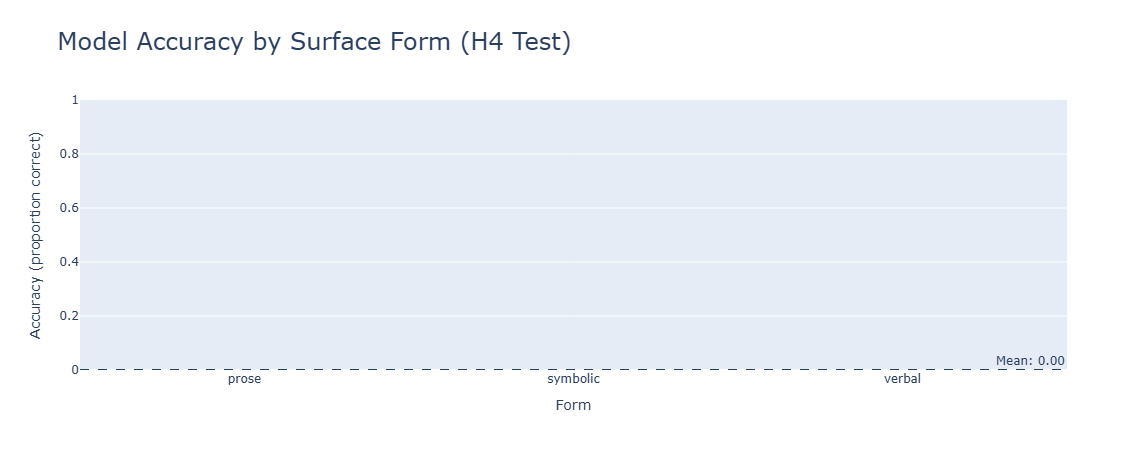

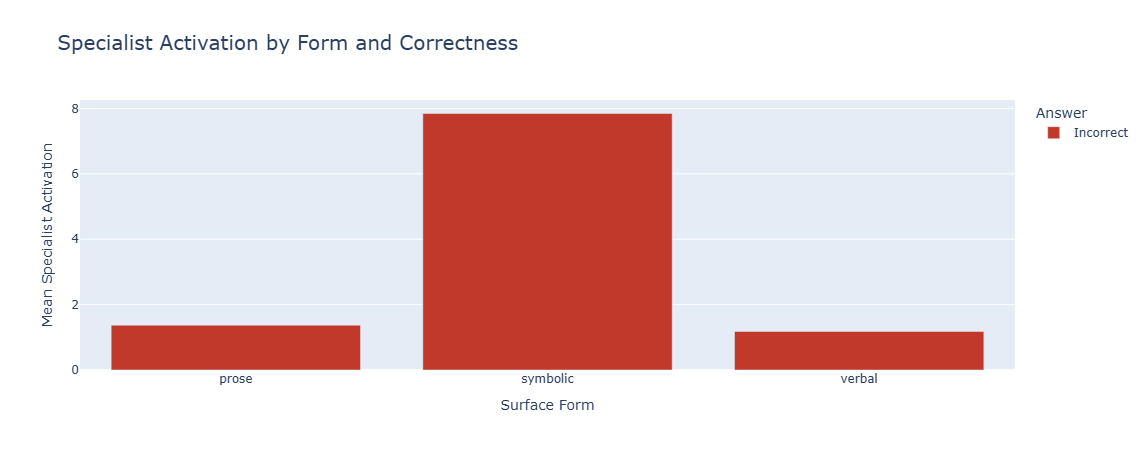

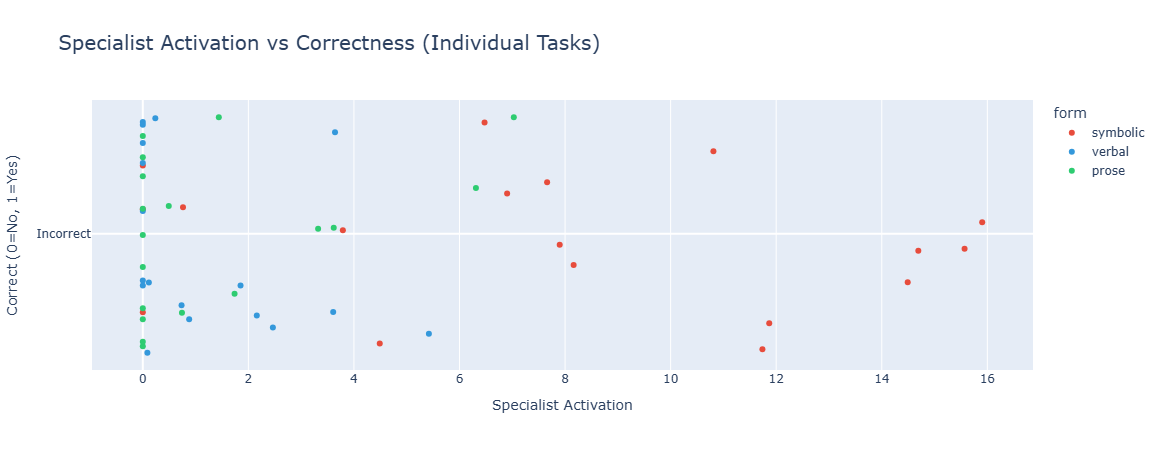

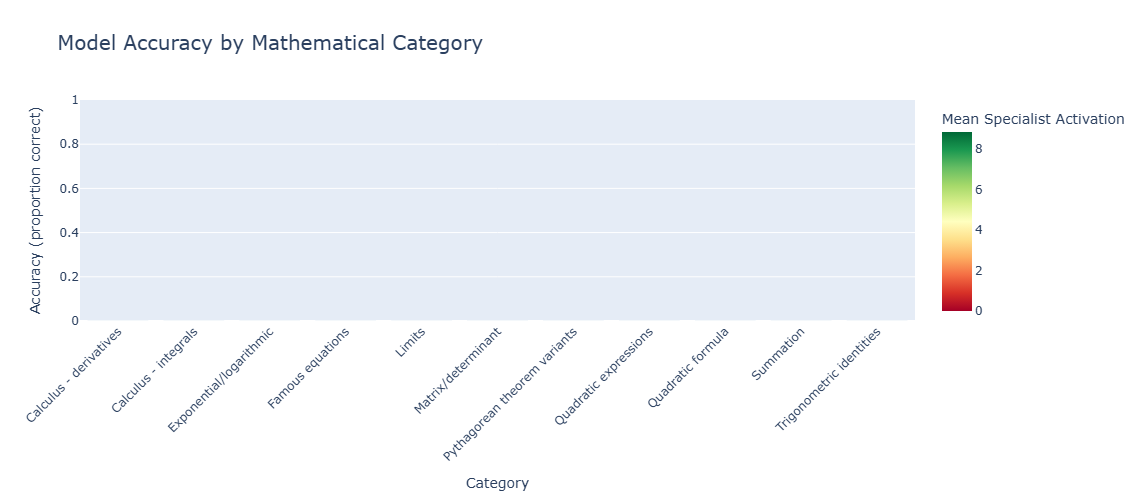


📊 HYPOTHESIS H4 ASSESSMENT

H4: Model accuracy correlates with specialist activation strength.
    Test: Do higher-activation inputs show better accuracy?

Summary by Form:
   Symbolic:  Accuracy = 0.0%, Mean Activation = 7.85
   Verbal:    Accuracy = 0.0%, Mean Activation = 1.18
   Prose:     Accuracy = 0.0%, Mean Activation = 1.37

Activation ranking (high to low): symbolic > prose > verbal
Accuracy ranking (high to low):   symbolic > verbal > prose

📌 CONCLUSION:
   ⚠️ H4 CANNOT BE ASSESSED
   Need both correct and incorrect answers to compare activations

📝 Additional Observations:
   • Symbolic forms have highest specialist activation (as expected from H1)
   • Accuracy is similar across forms
   • Activation ranking does NOT match accuracy ranking



In [17]:
# ============================================================================
# CELL 18: Behavioral Accuracy Analysis (H4 - Behavioral Correlation)
# ============================================================================
print("\n🎯 BEHAVIORAL ACCURACY ANALYSIS: Specialist Activation vs Model Performance (H4)")
print("=" * 70)
print("""
Hypothesis H4: Model accuracy on mathematical completions will correlate 
with specialist activation strength. Inputs that strongly activate the 
math specialist will be answered correctly more often than inputs that 
do not activate it.

If H4 is supported: Interpretability findings have direct behavioral implications.
If H4 is not supported: Specialist features may not causally influence behavior.
""")

# -----------------------------------------------------------------------------
# Step 1: Review math_pairs for completion testing
# -----------------------------------------------------------------------------
print("1️⃣ Using math_pairs for completion tasks...")
print(f"   {len(math_pairs)} tasks with expected answers")
print(f"   Categories: {sorted(set(p['category'] for p in math_pairs))}")

# Show sample
print("\n   Sample task:")
print(f"   Symbolic: {math_pairs[0]['symbolic']}")
print(f"   Verbal:   {math_pairs[0]['verbal']}")
print(f"   Prose:    {math_pairs[0]['prose']}")
print(f"   Category: {math_pairs[0]['category']}")
print(f"   Expected: {math_pairs[0]['expected']}")

# -----------------------------------------------------------------------------
# Step 2: Generate Model Completions
# -----------------------------------------------------------------------------
print("\n2️⃣ Generating model completions...")

def get_completion(prompt, max_new_tokens=5):
    """Generate completion for a prompt and return the first few tokens."""
    tokens = model.to_tokens(prompt, prepend_bos=True)
    
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(tokens)
            next_token = logits[0, -1, :].argmax()
            tokens = torch.cat([tokens, next_token.unsqueeze(0).unsqueeze(0)], dim=1)
    
    # Decode only the new tokens
    full_text = model.tokenizer.decode(tokens[0])
    completion = full_text[len(prompt):]
    return completion.strip()

def check_answer(completion, expected):
    """Check if completion starts with or contains the expected answer."""
    completion_clean = completion.lower().strip()
    expected_clean = expected.lower().strip()
    
    # Check if completion starts with expected
    if completion_clean.startswith(expected_clean):
        return True
    # Check if expected appears in first part of completion
    if expected_clean in completion_clean[:len(expected_clean) + 5]:
        return True
    # Handle numeric matches (e.g., "1" vs "one")
    number_words = {'0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
                    '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine'}
    if expected_clean in number_words and number_words[expected_clean] in completion_clean:
        return True
    if expected_clean in number_words.values():
        for digit, word in number_words.items():
            if expected_clean == word and digit in completion_clean[:5]:
                return True
    return False

# Run completions for all tasks and forms
results_list = []

for task in math_pairs:
    for form in ['symbolic', 'verbal', 'prose']:
        prompt = task[form]
        completion = get_completion(prompt, max_new_tokens=5)
        is_correct = check_answer(completion, task['expected'])
        
        results_list.append({
            'task': task['symbolic'],
            'form': form,
            'prompt': prompt,
            'completion': completion,
            'expected': task['expected'],
            'correct': is_correct,
            'category': task['category']
        })
        
print(f"   Generated {len(results_list)} completions")

# -----------------------------------------------------------------------------
# Step 3: Extract Specialist Activations for Prompts
# -----------------------------------------------------------------------------
print("\n3️⃣ Extracting specialist activations for each prompt...")

# Use layer 11 specialist (best performing in Phase 3)
analysis_sae = "11-res-jb"
specialist_feature = form_activations_by_layer[analysis_sae]['specialist_idx']
sae_obj = loaded_saes[analysis_sae]['sae']
hook_point = loaded_saes[analysis_sae]['config']['hook_point']

print(f"   Using Math specialist: Feature #{specialist_feature} from {analysis_sae}")

# Extract activations for each prompt
for result in results_list:
    prompt = result['prompt']
    features = extract_features([prompt], sae_obj, hook_point)
    activation = features[0, specialist_feature].item()
    result['specialist_activation'] = activation

print(f"   Extracted specialist activations for {len(results_list)} prompts")

# -----------------------------------------------------------------------------
# Step 4: Create Results DataFrame
# -----------------------------------------------------------------------------
print("\n4️⃣ Compiling results...")

df_results = pd.DataFrame(results_list)

# Summary by form
display(HTML(f"""
<h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    Completion Results by Surface Form
</h3>
"""))

summary_by_form = df_results.groupby('form').agg({
    'correct': ['sum', 'count', 'mean'],
    'specialist_activation': 'mean'
}).round(3)
summary_by_form.columns = ['Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']
summary_by_form = summary_by_form.reset_index()
summary_by_form.columns = ['Form', 'Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']

display(summary_by_form)

# Summary by category
display(HTML(f"""
<h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    Completion Results by Category
</h3>
"""))

summary_by_category = df_results.groupby('category').agg({
    'correct': ['sum', 'count', 'mean'],
    'specialist_activation': 'mean'
}).round(3)
summary_by_category.columns = ['Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']
summary_by_category = summary_by_category.reset_index()
summary_by_category.columns = ['Category', 'Correct', 'Total', 'Accuracy', 'Mean Specialist Activation']

display(summary_by_category)

# -----------------------------------------------------------------------------
# Step 5: Detailed Results Table
# -----------------------------------------------------------------------------
print("\n5️⃣ Detailed completion results...")

display(HTML(f"""
<h3 style='font-family: "Open Sans", verdana, arial, sans-serif; font-size: 20px; color: #333;'>
    Individual Task Results
</h3>
"""))

# Create a cleaner display table
display_df = df_results[['task', 'form', 'prompt', 'completion', 'expected', 'correct', 'specialist_activation', 'category']].copy()
display_df['specialist_activation'] = display_df['specialist_activation'].round(2)
display_df['correct'] = display_df['correct'].map({True: '✅', False: '❌'})
display_df.columns = ['Task', 'Form', 'Prompt', 'Model Output', 'Expected', 'Correct', 'Specialist Act.', 'Category']

display(display_df)

# -----------------------------------------------------------------------------
# Step 6: Accuracy vs Activation Analysis
# -----------------------------------------------------------------------------
print("\n6️⃣ Analyzing accuracy vs specialist activation correlation...")

# Group by correctness
correct_activations = df_results[df_results['correct'] == True]['specialist_activation'].values
incorrect_activations = df_results[df_results['correct'] == False]['specialist_activation'].values

print(f"\nCorrect answers (n={len(correct_activations)}):")
print(f"   Mean specialist activation: {np.mean(correct_activations):.3f}" if len(correct_activations) > 0 else "   No correct answers")

print(f"\nIncorrect answers (n={len(incorrect_activations)}):")
print(f"   Mean specialist activation: {np.mean(incorrect_activations):.3f}" if len(incorrect_activations) > 0 else "   No incorrect answers")

# Statistical test if we have both groups
if len(correct_activations) > 1 and len(incorrect_activations) > 1:
    t_stat, p_value = stats.ttest_ind(correct_activations, incorrect_activations)
    print(f"\nIndependent t-test:")
    print(f"   t-statistic: {t_stat:.3f}")
    print(f"   p-value: {p_value:.4f}")
else:
    t_stat, p_value = None, None
    print("\n   (Insufficient data for t-test)")

# Point-biserial correlation (binary outcome vs continuous predictor)
from scipy.stats import pointbiserialr
if len(df_results) > 2 and df_results['correct'].nunique() > 1:
    corr, p_corr = pointbiserialr(df_results['correct'].astype(int), df_results['specialist_activation'])
    print(f"\nPoint-biserial correlation (accuracy vs activation):")
    print(f"   r = {corr:.3f}")
    print(f"   p = {p_corr:.4f}")

# -----------------------------------------------------------------------------
# Step 7: Visualization - Accuracy by Form
# -----------------------------------------------------------------------------
print("\n7️⃣ Visualizing results...")

# Bar chart: Accuracy by form
fig_accuracy = px.bar(
    summary_by_form,
    x='Form',
    y='Accuracy',
    color='Form',
    title='Model Accuracy by Surface Form (H4 Test)',
    color_discrete_map={'symbolic': '#e74c3c', 'verbal': '#3498db', 'prose': '#2ecc71'}
)

fig_accuracy.update_layout(
    title={'font': {'size': 24}},
    height=450,
    width=700,
    yaxis_title='Accuracy (proportion correct)',
    yaxis_range=[0, 1],
    showlegend=False
)

fig_accuracy.add_hline(y=summary_by_form['Accuracy'].mean(), line_dash="dash", 
                       annotation_text=f"Mean: {summary_by_form['Accuracy'].mean():.2f}")

fig_accuracy.show()

# -----------------------------------------------------------------------------
# Step 8: Visualization - Activation vs Correctness
# -----------------------------------------------------------------------------

# Grouped bar: Mean activation by form and correctness
activation_by_correct = df_results.groupby(['form', 'correct'])['specialist_activation'].mean().reset_index()
activation_by_correct['correct'] = activation_by_correct['correct'].map({True: 'Correct', False: 'Incorrect'})

fig_activation = px.bar(
    activation_by_correct,
    x='form',
    y='specialist_activation',
    color='correct',
    barmode='group',
    title='Specialist Activation by Form and Correctness',
    color_discrete_map={'Correct': '#27ae60', 'Incorrect': '#c0392b'}
)

fig_activation.update_layout(
    title={'font': {'size': 20}},
    height=450,
    width=700,
    xaxis_title='Surface Form',
    yaxis_title='Mean Specialist Activation',
    legend_title='Answer'
)

fig_activation.show()

# -----------------------------------------------------------------------------
# Step 9: Scatter Plot - Individual Points
# -----------------------------------------------------------------------------

# Scatter plot of activation vs correctness (jittered for visibility)
df_plot = df_results.copy()
df_plot['correct_jitter'] = df_plot['correct'].astype(int) + np.random.uniform(-0.1, 0.1, len(df_plot))

fig_scatter = px.scatter(
    df_plot,
    x='specialist_activation',
    y='correct_jitter',
    color='form',
    hover_data=['task', 'prompt', 'completion', 'category'],
    title='Specialist Activation vs Correctness (Individual Tasks)',
    color_discrete_map={'symbolic': '#e74c3c', 'verbal': '#3498db', 'prose': '#2ecc71'}
)

fig_scatter.update_layout(
    title={'font': {'size': 20}},
    height=450,
    width=800,
    xaxis_title='Specialist Activation',
    yaxis_title='Correct (0=No, 1=Yes)',
    yaxis_tickvals=[0, 1],
    yaxis_ticktext=['Incorrect', 'Correct']
)

fig_scatter.show()

# -----------------------------------------------------------------------------
# Step 10: Accuracy by Category Visualization
# -----------------------------------------------------------------------------

fig_category = px.bar(
    summary_by_category.sort_values('Accuracy', ascending=False),
    x='Category',
    y='Accuracy',
    color='Mean Specialist Activation',
    title='Model Accuracy by Mathematical Category',
    color_continuous_scale='RdYlGn'
)

fig_category.update_layout(
    title={'font': {'size': 20}},
    height=500,
    width=900,
    yaxis_title='Accuracy (proportion correct)',
    yaxis_range=[0, 1],
    xaxis_tickangle=-45
)

fig_category.show()

# -----------------------------------------------------------------------------
# Step 11: H4 Assessment
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📊 HYPOTHESIS H4 ASSESSMENT")
print("=" * 70)

print("\nH4: Model accuracy correlates with specialist activation strength.")
print("    Test: Do higher-activation inputs show better accuracy?\n")

# Calculate key metrics
symbolic_accuracy = df_results[df_results['form'] == 'symbolic']['correct'].mean()
verbal_accuracy = df_results[df_results['form'] == 'verbal']['correct'].mean()
prose_accuracy = df_results[df_results['form'] == 'prose']['correct'].mean()

symbolic_activation = df_results[df_results['form'] == 'symbolic']['specialist_activation'].mean()
verbal_activation = df_results[df_results['form'] == 'verbal']['specialist_activation'].mean()
prose_activation = df_results[df_results['form'] == 'prose']['specialist_activation'].mean()

print("Summary by Form:")
print(f"   Symbolic:  Accuracy = {symbolic_accuracy:.1%}, Mean Activation = {symbolic_activation:.2f}")
print(f"   Verbal:    Accuracy = {verbal_accuracy:.1%}, Mean Activation = {verbal_activation:.2f}")
print(f"   Prose:     Accuracy = {prose_accuracy:.1%}, Mean Activation = {prose_activation:.2f}")

# Check if activation order matches accuracy order
activation_order = sorted(['symbolic', 'verbal', 'prose'], 
                          key=lambda x: df_results[df_results['form'] == x]['specialist_activation'].mean(),
                          reverse=True)
accuracy_order = sorted(['symbolic', 'verbal', 'prose'],
                        key=lambda x: df_results[df_results['form'] == x]['correct'].mean(),
                        reverse=True)

print(f"\nActivation ranking (high to low): {' > '.join(activation_order)}")
print(f"Accuracy ranking (high to low):   {' > '.join(accuracy_order)}")

# Assess H4
print("\n📌 CONCLUSION:")

if len(correct_activations) > 0 and len(incorrect_activations) > 0:
    mean_correct = np.mean(correct_activations)
    mean_incorrect = np.mean(incorrect_activations)
    
    if p_value is not None:
        if mean_correct > mean_incorrect and p_value < 0.05:
            print("   ✅ H4 SUPPORTED")
            print(f"   Correct answers have higher specialist activation ({mean_correct:.2f}) than incorrect ({mean_incorrect:.2f})")
            print(f"   Difference is statistically significant (p = {p_value:.4f})")
            print("   This suggests specialist features have behavioral relevance.")
        elif mean_correct > mean_incorrect:
            print("   ⚠️ H4 PARTIALLY SUPPORTED")
            print(f"   Correct answers have higher specialist activation ({mean_correct:.2f}) than incorrect ({mean_incorrect:.2f})")
            print(f"   But difference is not statistically significant (p = {p_value:.4f})")
            print("   Trend is in expected direction but needs more data.")
        elif mean_correct < mean_incorrect and p_value < 0.05:
            print("   ❌ H4 NOT SUPPORTED (opposite pattern)")
            print(f"   Incorrect answers have HIGHER activation ({mean_incorrect:.2f}) than correct ({mean_correct:.2f})")
            print("   Specialist activation may not causally influence accuracy.")
        else:
            print("   ⚠️ H4 INCONCLUSIVE")
            print(f"   No clear relationship between activation and accuracy")
            print(f"   Correct: {mean_correct:.2f}, Incorrect: {mean_incorrect:.2f}, p = {p_value:.4f}")
    else:
        print("   ⚠️ H4 INCONCLUSIVE (insufficient data for statistical test)")
        print(f"   Correct: {mean_correct:.2f}, Incorrect: {mean_incorrect:.2f}")
else:
    print("   ⚠️ H4 CANNOT BE ASSESSED")
    print("   Need both correct and incorrect answers to compare activations")

# Additional insight about form-based patterns
print("\n📝 Additional Observations:")
if symbolic_activation > verbal_activation and symbolic_activation > prose_activation:
    print("   • Symbolic forms have highest specialist activation (as expected from H1)")
if symbolic_accuracy != verbal_accuracy or symbolic_accuracy != prose_accuracy:
    print(f"   • Accuracy varies by form: {symbolic_accuracy:.0%} (sym) vs {verbal_accuracy:.0%} (verb) vs {prose_accuracy:.0%} (prose)")
else:
    print("   • Accuracy is similar across forms")

if activation_order == accuracy_order:
    print("   • Activation ranking matches accuracy ranking (supports H4)")
else:
    print(f"   • Activation ranking does NOT match accuracy ranking")

print("\n" + "=" * 70)